In [1]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import pylab as plt
from nltk.corpus import words
import pandas as pd
import sys
from scipy import spatial, stats
from collections import Counter, defaultdict
from matplotlib.colors import ListedColormap
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from numpy import dot
from numpy.linalg import norm
import operator
from statistics import mean, stdev
from scipy.stats import pearsonr 
import math
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
import json
import networkx as nx
import copy
import pickle
import matplotlib.colors
#import geopandas
#from shapely.geometry import Point
#import mapclassify

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    #sys.stdout.write(str(d))
    sys.stdout.write('%d' % d)
    sys.stdout.flush()

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

C:\Users\ditong\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Read in Data

### 1. year, socName, N posts, education

In [2]:
# JOB YEAR NPOSTS
jyn = defaultdict(lambda:defaultdict(lambda:0))
yjn = defaultdict(lambda:defaultdict(lambda:0))
jye = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/year_socName_Nposts_aveMedianPay_aveMinEdu.txt',
          'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        year = int(line_lst[0])
        job = line_lst[1]
        num = int(line_lst[2])
        edu = line_lst[3]
        pay = line_lst[4]
        if year != 2019:
            jyn[job][year] = num
            yjn[year][job] = num
            if edu != 'nan' and edu != 'nan\n': 
                if float(edu) > 0:
                    jye[job][year] = float(edu)
#             if pay != 'nan' and pay != 'nan\n':
#                 med_pay = pay.split('_')[1]
#                 if med_pay != 'nan' and float(med_pay) > 0:
#                     jyp[job][year] = float(med_pay)

### 2. socName - meta (ave. pay, ave. edu, 2-digits soc group)

In [12]:
oe={}
op={}
ocg={}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/socName_aveMedianPay_aveMinEdu_socGroup.txt','r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        job = line_lst[0]
        op[job] = float(line_lst[1])
        oe[job] = float(line_lst[2])
        ocg[job] = line_lst[3]

In [13]:
# SOC GROUP--6 digit SOC
go=defaultdict(lambda:set())
for o in ocg:
    go[ocg[o]].add(o)
len(ocg), len(go)

(838, 22)

### 3. year - socName - skill freq

In [5]:
# JOB-SKILL DATA
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    yjas[year][job][skill] = tfidf

In [ ]:
# job - top 5% defining skills
jys = defaultdict(lambda:defaultdict(lambda:[]))
syj = defaultdict(lambda:defaultdict(lambda:[]))
for year in yjas:
    for job in yjas[year]:
        threshold = np.quantile(list(yjas[year][job].values()), [0.95])
        #threshold = np.mean(list(yjas[year][job].values()))
        for skill in yjas[year][job]:
            if yjas[year][job][skill] > threshold:
                jys[job][year].append(skill)
                syj[skill][year].append(job)
        if len(jys[job][year]) < 5:
            #print(job, year)
            del jys[job][year]
            fulllist = syj[skill][year]
            syj[skill][year] = [value for value in fulllist if value != job]

In [16]:
len(jys), len(syj)

(831, 4915)

In [17]:
# job - SKILL NUMBER
osn = {}
for job in jys:
    snlst = []
    for yr in jys[job]:
        if len(jys[job][yr]) != 0:
            snlst.append(len(jys[job][yr]))
    if snlst:
        osn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
osn = dict(sorted(osn.items(), key=operator.itemgetter(1),reverse=True))

### 4(1)a. Large company year - socName - skill freq

In [9]:
# Large Company JOB-SKILL DATA
# without filtering the skills
lcyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/lc10_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    lcyjas[year][job][skill] = tfidf

# filter the defining skills
lcjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in lcyjas:
    for job in lcyjas[year]:
        threshold = np.quantile(list(lcyjas[year][job].values()), [0.95])
        #threshold = min(list(yjas[year][job].values()))
        for skill in lcyjas[year][job]:
            if lcyjas[year][job][skill] > threshold:
                lcjys[job][year].append(skill)
        if len(lcjys[job][year]) < 5:
            del lcjys[job][year]

In [10]:
# large company SKILL NUMBER
lcosn = {}
for job in lcjys:
    snlst = []
    for yr in lcjys[job]:
        if len(lcjys[job][yr]) != 0:
            snlst.append(len(lcjys[job][yr]))
    if snlst:
        lcosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
lcosn = dict(sorted(lcosn.items(), key=operator.itemgetter(1),reverse=True))

### 4(1)b. Small company year - socName - skill freq

In [11]:
# Small Company JOB-SKILL DATA
# without filtering the skills
scyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/sc10_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    scyjas[year][job][skill] = tfidf

# filter the defining skills
scjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in scyjas:
    for job in scyjas[year]:
        threshold = np.quantile(list(scyjas[year][job].values()), [0.95])
        #threshold = min(list(yjas[year][job].values()))
        for skill in scyjas[year][job]:
            if scyjas[year][job][skill] >= threshold:
                scjys[job][year].append(skill)
        if len(scjys[job][year]) < 5:
            del scjys[job][year]  

In [12]:
# small company SKILL NUMBER
scosn = {}
for job in scjys:
    snlst = []
    for yr in scjys[job]:
        if len(scjys[job][yr]) != 0:
            snlst.append(len(scjys[job][yr]))
    if snlst:
        scosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
scosn = dict(sorted(scosn.items(), key=operator.itemgetter(1),reverse=True))

### 4(2)a. Large Market year - socName - skill freq 

In [13]:
# Large Company JOB-SKILL DATA
# without filtering the skills
llocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/lloc1_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    llocyjas[year][job][skill] = tfidf

# filter the defining skills
llocjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in llocyjas:
    for job in llocyjas[year]:
        threshold = np.quantile(list(llocyjas[year][job].values()), [0.95])
        #threshold = min(list(yjas[year][job].values()))
        for skill in llocyjas[year][job]:
            if llocyjas[year][job][skill] > threshold:
                llocjys[job][year].append(skill)
        if len(llocjys[job][year]) < 5:
            del llocjys[job][year]

In [14]:
# large location SKILL NUMBER
llocosn = {}
for job in llocjys:
    snlst = []
    for yr in llocjys[job]:
        if len(llocjys[job][yr]) != 0:
            snlst.append(len(llocjys[job][yr]))
    if snlst:
        llocosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
llocosn = dict(sorted(llocosn.items(), key=operator.itemgetter(1),reverse=True))

### 4(2)b. Small Market year - socName - skill freq 

In [15]:
# Small market JOB-SKILL DATA
# without filtering the skills
slocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/sloc1_occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year != 2019:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    slocyjas[year][job][skill] = tfidf

# filter the defining skills
slocjys = defaultdict(lambda:defaultdict(lambda:[]))
for year in slocyjas:
    for job in slocyjas[year]:
        threshold = np.quantile(list(slocyjas[year][job].values()), [0.95])
        #threshold = min(list(yjas[year][job].values()))
        for skill in slocyjas[year][job]:
            if slocyjas[year][job][skill] >= threshold:
                slocjys[job][year].append(skill)
        if len(slocjys[job][year]) < 5:
            del slocjys[job][year]  

In [16]:
# small market SKILL NUMBER
slocosn = {}
for job in slocjys:
    snlst = []
    for yr in slocjys[job]:
        if len(slocjys[job][yr]) != 0:
            snlst.append(len(slocjys[job][yr]))
    if snlst:
        slocosn[job] = round(np.mean(snlst)) 
slocosn = dict(sorted(slocosn.items(), key=operator.itemgetter(1),reverse=True))

### Company Size by Occupation Size

In [560]:
# Large Company Large market JOB-SKILL DATA
# without filtering the skills
# lcllocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
# with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/lclloc_occ_year_skill_freq.txt', 'r') as f:
#     for line in f:
#         line_lst = line.split("\t")
#         job = line_lst[0]
#         year = int(line_lst[1])
#         skills = line_lst[2:]
#         if year != 2019:
#             if len(skills) > 5:
#                 for skill_tfidf in skills:
#                     skill = skill_tfidf.split('_')[0].lower()
#                     tfidf = float(skill_tfidf.split('_')[1])
#                     lcllocyjas[year][job][skill] = tfidf

# # filter the defining skills
# lcllocjys = defaultdict(lambda:defaultdict(lambda:[]))
# for year in lcllocyjas:
#     for job in lcllocyjas[year]:
#         threshold = np.quantile(list(lcllocyjas[year][job].values()), [0.95])
#         #threshold = min(list(yjas[year][job].values()))
#         for skill in lcllocyjas[year][job]:
#             if lcllocyjas[year][job][skill] > threshold:
#                 lcllocjys[job][year].append(skill)
#         if len(lcllocjys[job][year]) < 5:
#             del lcllocjys[job][year]

In [561]:
# Large Company Small market JOB-SKILL DATA
# without filtering the skills
# lcslocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
# with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/lcsloc_occ_year_skill_freq.txt', 'r') as f:
#     for line in f:
#         line_lst = line.split("\t")
#         job = line_lst[0]
#         year = int(line_lst[1])
#         skills = line_lst[2:]
#         if year != 2019:
#             if len(skills) > 5:
#                 for skill_tfidf in skills:
#                     skill = skill_tfidf.split('_')[0].lower()
#                     tfidf = float(skill_tfidf.split('_')[1])
#                     lcslocyjas[year][job][skill] = tfidf

# # filter the defining skills
# lcslocjys = defaultdict(lambda:defaultdict(lambda:[]))
# for year in lcslocyjas:
#     for job in lcslocyjas[year]:
#         threshold = np.quantile(list(lcslocyjas[year][job].values()), [0.95])
#         #threshold = min(list(yjas[year][job].values()))
#         for skill in lcslocyjas[year][job]:
#             if lcslocyjas[year][job][skill] > threshold:
#                 lcslocjys[job][year].append(skill)
#         if len(lcslocjys[job][year]) < 5:
#             del lcslocjys[job][year]

In [562]:
# Small Company Large market JOB-SKILL DATA
# without filtering the skills
# scllocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
# with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/sclloc_occ_year_skill_freq.txt', 'r') as f:
#     for line in f:
#         line_lst = line.split("\t")
#         job = line_lst[0]
#         year = int(line_lst[1])
#         skills = line_lst[2:]
#         if year != 2019:
#             if len(skills) > 5:
#                 for skill_tfidf in skills:
#                     skill = skill_tfidf.split('_')[0].lower()
#                     tfidf = float(skill_tfidf.split('_')[1])
#                     scllocyjas[year][job][skill] = tfidf

# # filter the defining skills
# scllocjys = defaultdict(lambda:defaultdict(lambda:[]))
# for year in scllocyjas:
#     for job in scllocyjas[year]:
#         threshold = np.quantile(list(scllocyjas[year][job].values()), [0.95])
#         #threshold = min(list(yjas[year][job].values()))
#         for skill in scllocyjas[year][job]:
#             if scllocyjas[year][job][skill] > threshold:
#                 scllocjys[job][year].append(skill)
#         if len(scllocjys[job][year]) < 5:
#             del scllocjys[job][year]

In [563]:
# Small Company small market JOB-SKILL DATA
# without filtering the skills
# scslocyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
# with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/scsloc_occ_year_skill_freq.txt', 'r') as f:
#     for line in f:
#         line_lst = line.split("\t")
#         job = line_lst[0]
#         year = int(line_lst[1])
#         skills = line_lst[2:]
#         if year != 2019:
#             if len(skills) > 5:
#                 for skill_tfidf in skills:
#                     skill = skill_tfidf.split('_')[0].lower()
#                     tfidf = float(skill_tfidf.split('_')[1])
#                     scslocyjas[year][job][skill] = tfidf

# # filter the defining skills
# scslocjys = defaultdict(lambda:defaultdict(lambda:[]))
# for year in scslocyjas:
#     for job in scslocyjas[year]:
#         threshold = np.quantile(list(scslocyjas[year][job].values()), [0.95])
#         #threshold = min(list(yjas[year][job].values()))
#         for skill in scslocyjas[year][job]:
#             if scslocyjas[year][job][skill] > threshold:
#                 scslocjys[job][year].append(skill)
#         if len(scslocjys[job][year]) < 5:
#             del scslocjys[job][year]

### 5. Skill Network

In [18]:
# skill network
graph_dict = {}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/skillpair_pmi.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        graph_dict[(int(line_lst[0]), int(line_lst[1]))] = float(line_lst[2])
        
        
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/2010_skill_id_name.json','r')as f:
    name_dict = json.load(f)
name_index = {name_dict[i]:int(i) for i in name_dict}
name_dict = {int(i):name_dict[i] for i in name_dict.keys()}

PMI = nx.Graph()
for pair in graph_dict:
    if graph_dict[pair] > 0:
        i, j = pair
        PMI.add_edge(name_dict[i], name_dict[j], weight = graph_dict[pair])
    
len(PMI),len(PMI.edges)

# pair-weight
pw={(i,j):PMI[i][j]['weight'] for i,j in PMI.edges()}
# node1-node2-weight
ppmi = defaultdict(lambda:defaultdict(lambda:0))
for i,j in pw:
    ppmi[i][j] = pw[(i,j)]
# node1 - sorted connected nodes
spmi = defaultdict(lambda:[])
for i in ppmi:
    sl = sorted([(p,j) for j, p in ppmi[i].items()],reverse=True)
    sj = [j for p, j in sl]
    spmi[i] = sj

#### Skill community

In [ ]:
partition = community_louvain.best_partition(PMI)
modularity = round(community_louvain.modularity(partition, PMI), 2) # 0.51
with open('partition_0.0_0.0_6_0.51.txt','w') as f:
        for k,v in partition.items():
            line = '\t'.join([k, str(v)])
            f.write(line + '\n')

In [19]:
# skill--community
partition = defaultdict(lambda:[])
sp = {}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/partition_0.0_0.0_6_0.51.txt','r') as f:
    for line in f:
        skill = line.split('\t')[0]
        group = int(line.split('\t')[1])
        partition[group].append(skill)
        sp[skill] = group

# community labels
labels = ['business and managerial skills', 'engineering, technical, and manual skills', 
          'computer and programming skills', 'clerical and analytical skills', 
          'scientific and research skills', 'medical and health skills']

#### Positions for Communities

In [ ]:
# generating positions * 6 ---> save as postitions.txt
# one example: pos0
e0 = [(from_node,to_node,edge_attributes) for from_node,to_node,edge_attributes in PMI.edges(data=True) 
                  if sp[from_node]==0 and sp[to_node]==0]
g0 = nx.Graph()
g0.add_edges_from(e0)
from networkx.algorithms import tree
t0 = list(tree.maximum_spanning_edges(g0, algorithm="kruskal", data=False))
f0 = nx.Graph()
f0.add_edges_from(t0)
pos0 = nx.spring_layout(f0)
xs,ys=np.array(list(pos0.values())).T

In [20]:
# read in saved positions for the six communities
pos0=defaultdict(lambda:defaultdict(lambda:''))
pos1=defaultdict(lambda:defaultdict(lambda:''))
pos2=defaultdict(lambda:defaultdict(lambda:''))
pos3=defaultdict(lambda:defaultdict(lambda:''))
pos4=defaultdict(lambda:defaultdict(lambda:''))
pos5=defaultdict(lambda:defaultdict(lambda:''))
with open("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/positions.txt", "r") as f:
    for line in f:
        line_lst = line[:-1].split("\t")
        posn = line_lst[0]
        skill = line_lst[1]
        posi = (float(line_lst[2]), float(line_lst[3]))
        if posn == 'pos0':
            pos0[skill] = posi
        elif posn == 'pos1':
            pos1[skill] = posi
        elif posn == 'pos2':
            pos2[skill] = posi
        elif posn == 'pos3':
            pos3[skill] = posi
        elif posn == 'pos4':
            pos4[skill] = posi
        elif posn == 'pos5':
            pos5[skill] = posi

###  6. skill embedding (all years)

In [18]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

#### Job Vector

In [19]:
# 200 dimension Job-Year-Vector
yjv = defaultdict(lambda:defaultdict(lambda:''))
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    for y in jys[j]:
        jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        yjv[y][j] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        #jyv[j][y] = np.sum([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

#### Job Vector Change 

In [20]:
# job stability from 2010 to 2018: dot product between 2 job vectors
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

In [21]:
len(jyv), len(jtr)

(805, 727)

In [22]:
# median job skill change
np.quantile(list(jtr.values()), [0.5])

array([0.02708179])

#### Large and small company job vector and job vector change

In [26]:
# large and small company: 200 dimension Job-Year-Vector
lcjyv = defaultdict(lambda:defaultdict(lambda:''))
scjyv = defaultdict(lambda:defaultdict(lambda:''))
for j in lcjys:
    for y in lcjys[j]:
        lcjyv[j][y] = np.mean([model.wv[s] for s in lcjys[j][y] if s in model.wv], axis=0) 
for j in scjys:
    for y in scjys[j]:      
        scjyv[j][y] = np.mean([model.wv[s] for s in scjys[j][y] if s in model.wv], axis=0)
        
# large and small company job transformation from 2010 to 2018: dot product between 2 job vectors
lcjtr = {}
k=0
for j in lcjyv:
    if 2010 in lcjyv[j] and 2018 in lcjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrrr = np.dot(lcjyv[j][2018], lcjyv[j][2010])/(np.linalg.norm(lcjyv[j][2018])* np.linalg.norm(lcjyv[j][2010]))
                if type(jtrrr) == np.float32:
                    lcjtr[j] = 1 - jtrrr
    else:
        k+=1
                
lcjtr = dict(sorted(lcjtr.items(), key=operator.itemgetter(1)))

scjtr = {}
k=0
for j in scjyv:
    if 2010 in scjyv[j] and 2018 in scjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrr = np.dot(scjyv[j][2018], scjyv[j][2010])/(np.linalg.norm(scjyv[j][2018])* np.linalg.norm(scjyv[j][2010]))
                if type(jtrr) == np.float32:
                    scjtr[j] = 1 - jtrr
    else:
        k+=1
        
scjtr = dict(sorted(scjtr.items(), key=operator.itemgetter(1)))
len(lcjtr), len(scjtr),len(jtr)

(673, 564, 727)

#### Large and small market size job vector and job vector change

In [27]:
# large and small company: 200 dimension Job-Year-Vector
llocjyv = defaultdict(lambda:defaultdict(lambda:''))
slocjyv = defaultdict(lambda:defaultdict(lambda:''))
for j in llocjys:
    for y in llocjys[j]:
        llocjyv[j][y] = np.mean([model.wv[s] for s in llocjys[j][y] if s in model.wv], axis=0) 
for j in slocjys:
    for y in slocjys[j]:      
        slocjyv[j][y] = np.mean([model.wv[s] for s in slocjys[j][y] if s in model.wv], axis=0)
        
# large and small company job transformation from 2010 to 2018: dot product between 2 job vectors
llocjtr = {}
for j in llocjyv:
    if 2010 in llocjyv[j] and 2018 in llocjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrrr = np.dot(llocjyv[j][2018], llocjyv[j][2010])/(np.linalg.norm(llocjyv[j][2018])* np.linalg.norm(llocjyv[j][2010]))
                if type(jtrrr) == np.float32:
                    llocjtr[j] = 1 - jtrrr
                
llocjtr = dict(sorted(llocjtr.items(), key=operator.itemgetter(1)))

slocjtr = {}
for j in slocjyv:
    if 2010 in slocjyv[j] and 2018 in slocjyv[j]:
        if j in jyn:
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtrr = np.dot(slocjyv[j][2018], slocjyv[j][2010])/(np.linalg.norm(slocjyv[j][2018])* np.linalg.norm(slocjyv[j][2010]))
                if type(jtrr) == np.float32:
                    slocjtr[j] = 1 - jtrr
        
slocjtr = dict(sorted(slocjtr.items(), key=operator.itemgetter(1)))
len(llocjtr), len(slocjtr)

(670, 552)

#### Company Size by Market Size job vector and job vector change

In [203]:
# # large and small market size by large and small company: 200 dimension Job-Year-Vector
# lcllocjyv = defaultdict(lambda:defaultdict(lambda:''))
# lcslocjyv = defaultdict(lambda:defaultdict(lambda:''))
# scllocjyv = defaultdict(lambda:defaultdict(lambda:''))
# scslocjyv = defaultdict(lambda:defaultdict(lambda:''))
# for j in lcllocjys:
#     for y in lcllocjys[j]:
#         lcllocjyv[j][y] = np.mean([model.wv[s] for s in lcllocjys[j][y] if s in model.wv], axis=0) 
        
# for j in lcslocjys:
#     for y in lcslocjys[j]:
#         lcslocjyv[j][y] = np.mean([model.wv[s] for s in lcslocjys[j][y] if s in model.wv], axis=0)
        
# for j in scllocjys:
#     for y in scllocjys[j]:      
#         scllocjyv[j][y] = np.mean([model.wv[s] for s in scllocjys[j][y] if s in model.wv], axis=0)
        
# for j in scslocjys:
#     for y in scslocjys[j]:      
#         scslocjyv[j][y] = np.mean([model.wv[s] for s in scslocjys[j][y] if s in model.wv], axis=0)
        
# # large and small market size by large and small company job transformation from 2010 to 2018: dot product between 2 job vectors
# lcllocjtr = {}
# for j in lcllocjyv:
#     if 2010 in lcllocjyv[j] and 2018 in lcllocjyv[j]:
#         if j in jyn:
#             if jyn[j][2010] > 100 and jyn[j][2018] > 100:
#                 jtrrr = np.dot(lcllocjyv[j][2018], lcllocjyv[j][2010]
#                               )/(np.linalg.norm(lcllocjyv[j][2018])* np.linalg.norm(lcllocjyv[j][2010]))
#                 if type(jtrrr) == np.float32:
#                     lcllocjtr[j] = 1 - jtrrr
                
# lcllocjtr = dict(sorted(lcllocjtr.items(), key=operator.itemgetter(1)))


# lcslocjtr = {}
# for j in lcslocjyv:
#     if 2010 in lcslocjyv[j] and 2018 in lcslocjyv[j]:
#         if j in jyn:
#             if jyn[j][2010] > 100 and jyn[j][2018] > 100:
#                 jtrrr = np.dot(lcslocjyv[j][2018], lcslocjyv[j][2010]
#                               )/(np.linalg.norm(lcslocjyv[j][2018])* np.linalg.norm(lcslocjyv[j][2010]))
#                 if type(jtrrr) == np.float32:
#                     lcslocjtr[j] = 1 - jtrrr
                
# lcslocjtr = dict(sorted(lcslocjtr.items(), key=operator.itemgetter(1)))


# scllocjtr = {}
# for j in scllocjyv:
#     if 2010 in scllocjyv[j] and 2018 in scllocjyv[j]:
#         if j in jyn:
#             if jyn[j][2010] > 100 and jyn[j][2018] > 100:
#                 jtrr = np.dot(scllocjyv[j][2018], scllocjyv[j][2010]
#                              )/(np.linalg.norm(scllocjyv[j][2018])* np.linalg.norm(scllocjyv[j][2010]))
#                 if type(jtrr) == np.float32:
#                     scllocjtr[j] = 1 - jtrr
        
# scllocjtr = dict(sorted(scllocjtr.items(), key=operator.itemgetter(1)))

# scslocjtr = {}
# for j in scslocjyv:
#     if 2010 in scslocjyv[j] and 2018 in scslocjyv[j]:
#         if j in jyn:
#             if jyn[j][2010] > 100 and jyn[j][2018] > 100:
#                 jtrr = np.dot(scslocjyv[j][2018], scslocjyv[j][2010]
#                              )/(np.linalg.norm(scslocjyv[j][2018])* np.linalg.norm(scslocjyv[j][2010]))
#                 if type(jtrr) == np.float32:
#                     scslocjtr[j] = 1 - jtrr
        
# scslocjtr = dict(sorted(scslocjtr.items(), key=operator.itemgetter(1)))


# len(lcllocjtr), len(lcslocjtr),len(scllocjtr),len(scslocjtr),len(jtr)

### 7. Cost of Change: Job average skill education change

In [54]:
# skill-year-entry education list
sminedul = defaultdict(lambda:[])
for s in syj:
    if 2018 in syj[s]:
        if syj[s][2018]:
            for j in syj[s][2018]:
                if j in jye:
                    if 2018 in jye[j]:
                        sminedul[s].append(jye[j][2018]) 

# skill-year-average entry education                        
sminedu={}
for s in sminedul:
    sminedu[s] = np.mean(sminedul[s])
sminedu = dict(sorted(sminedu.items(), key=operator.itemgetter(1), reverse=True))

In [24]:
jasec = {}
for j in jtr:
    if j in jys and j in jye:
        if 2010 in jye[j] and 2010 in jys[j] and 2018 in jys[j]: 
            newskills = [s for s in jys[j][2018] if s not in jys[j][2010]]
            nsedus=[]
            for s in newskills:
                if s in sminedu:
                    nsedus.append(sminedu[s])
            jasec[j] = np.mean(nsedus) - jye[j][2010]
            
jasec=dict(sorted(jasec.items(), key=operator.itemgetter(1), reverse=True))

In [25]:
# examples
jasec['Food Batchmakers'], jasec['Computer Programmers']

(1.4673485662401422, -0.5332061450260426)

In [40]:
# high edu and low edu jobs' education change
he=[]
le=[]
for j in jasec:
    if j in oe:
        if oe[j] > 16:
            he.append(jasec[j])
        else:
            le.append(jasec[j])
print(np.mean(he), np.mean(le))

-2.470189518674134 0.6547485301551728


In [53]:
# high pay and low pay jobs' education change
hp=[]
lp=[]
plist = [x for x in list(op.values()) if math.isnan(x) == False]
for j in jasec:
    if j in op:
        if op[j] >= np.quantile(plist, [0.75]):
            hp.append(jasec[j])
        elif op[j] < np.quantile(plist, [0.25]):
            lp.append(jasec[j])
print(np.mean(hp), np.mean(lp))

-1.6229159736683685 1.2938860389629918


### 8. Deming's Measurement

In [86]:
# replicated, 2018-2010
dfoccsc80_1 = pd.read_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/1018Soc6SkillChange_emp.csv')
occsc80_1 = {}
for i, j in zip(dfoccsc80_1["SOC"], dfoccsc80_1["SkillChange"]):
    occsc80_1[i] = j
    
len(occsc80_1)

820

## Figure 1a,b

In [87]:
# adjust positions and assign color to each cluster
colors = ['#bae4e3', '#bfdbf3', '#f3d6e8', '#fff0e1', '#a18ab0', '#8891a1']
oripos={0: pos0, 1:pos1, 2:pos2, 3:pos3, 4:pos4, 5:pos5}
movpos={0:(-0.2, -1),1:(-0.7, 1.2),2:(-1.7, 0.2),3:(1.2, -1.3),4:(1, 1),5:(2, 0)}
pos={}
col={}
for c in oripos:
    xm,ym=movpos[c]
    for p in oripos[c]:
        xp, yp=oripos[c][p]
        pos[p] = (xp+xm, yp+ym) 
        col[p] = colors[c]

In [89]:
# get nearest old skill for each new skill
newc = [s for s in jys["Computer Programmers"][2018] if s not in jys["Computer Programmers"][2010]]
dictpairc={}
dictlenc={}
for s in newc:
    if s in pos:
        dictpairc[s] = 0
        xi, xj = pos[s]
        dis=10000
        for s1 in jys["Computer Programmers"][2010]:
            if s1 in pos:
                xa,xb=pos[s1]
                d=(xi-xa)**2 + (xj-xb)**2
                if d < dis:
                    dictpairc[s] = s1
                    dis=d
        dictlenc[s]=dis

newj='Food Batchmakers'
newb = [s for s in jys[newj][2018] if s not in jys[newj][2010]]
dictpairb={}
dictlenb={}
for s in newb:
    if s in pos:
        dictpairb[s] = 0
        xi, xj = pos[s]
        dis=10000
        for s1 in jys[newj][2010]:
            xa,xb=pos[s1]
            d=(xi-xa)**2 + (xj-xb)**2
            if d < dis:
                dictpairb[s] = s1
                dis=d
                
        dictlenb[s]=dis

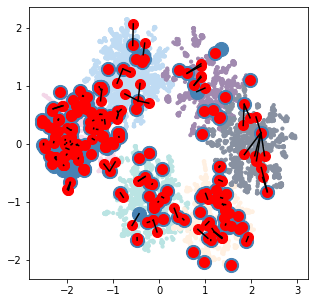

In [40]:
# figure 1a
x,y=np.array(list(pos.values())).T

fig = plt.figure(figsize=(5,5))

# computer programmer
ax1 = fig.add_subplot(111)
# all skills
plt.scatter(x,y,color=list(col.values()), s=10)
#2010
xc10,yc10=np.array(list(pos[i] for i in jys["Computer Programmers"][2010])).T
plt.scatter(xc10,yc10,color='steelblue', s=200)#, marker="x")
# 2018
xc18,yc18=np.array(list(pos[i] for i in jys["Computer Programmers"][2018] if i in pos)).T
plt.scatter(xc18,yc18,color='red', s=100)#, marker="o", facecolor="none")
# linking new skills to nearest old skills
for i,j in dictpairc.items():
    xi,yi = pos[i]
    xj,yj= pos[j]
    plt.plot([xi,xj],[yi, yj], color='k', zorder=10)
#     ax1.annotate("",xy=(xj,yj), xycoords='data',xytext=(xi,yi), textcoords='data',
#                 arrowprops=dict(arrowstyle="<-", color="black",shrinkA=5, shrinkB=5,
#                 patchA=None,patchB=None,connectionstyle='angle3,angleA=0,angleB=90',),zorder=1)
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig1/Fig1P1.pdf')  

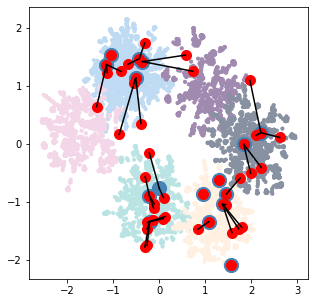

In [124]:
# figure 1b
x,y=np.array(list(pos.values())).T

fig = plt.figure(figsize=(5,5))
# FoodBatchmakers
ax2 = fig.add_subplot(111)
# all skills
plt.scatter(x,y,color=list(col.values()), s=10)
# 2010
xc10,yc10=np.array(list(pos[i] for i in jys[newj][2010])).T
plt.scatter(xc10,yc10,color='steelblue', s=200)#, marker="x")
#2018
xc18,yc18=np.array(list(pos[i] for i in jys[newj][2018] if i in pos)).T
plt.scatter(xc18,yc18,color='red', s=100)#, marker="o", facecolor="none")
# linking new skills to nearest old skills
for i,j in dictpairb.items():
    xi,yi = pos[i]
    xj,yj= pos[j]
    plt.plot([xi,xj],[yi, yj], color='k', zorder=10)
#     ax2.annotate("",xy=(xj,yj), xycoords='data',xytext=(xi,yi), textcoords='data',
#                 arrowprops=dict(arrowstyle="<-", color="black",shrinkA=5, shrinkB=5,
#                 patchA=None,patchB=None,connectionstyle='angle3,angleA=0,angleB=90',),zorder=1)
# for i in pos:
#     if i in slist:
#         x,y=pos[i]
#         #r=np.sqrt(x**2+y**2)
#         plt.text(x,y,i, fontsize=14, ha='left')
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig1/Fig1P2_FoodBatchmakers.pdf') 

## Figure 1c, d

In [92]:
# with employer job skill data
occ_y_freq=defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_npost_emp.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        freq = int(line_lst[2])
        if year == 2010 or year==2018:
            occ_y_freq[job][year] = freq

occ_y_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
occ_y_sfreq=defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq_emp.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if year in jyn[job]:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    occ_y_skill_freq[job][year][skill] = float(skill_tfidf.split('_')[1])
                    occ_y_sfreq[job][year] += float(skill_tfidf.split('_')[1])

# weights
jw1 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if 2010 in occ_y_sfreq[j] and 2018 in occ_y_sfreq[j]:
            jw1[j] = (occ_y_sfreq[j][2010] / occ_y_sfreq[j][2018]) / (occ_y_freq[j][2010]/occ_y_freq[j][2018])
            if jw1[j] > 1:
                jw1[j] = 1
                    
# skill probability
jysp = copy.deepcopy(occ_y_skill_freq)
for j in jysp:
    if j in occ_y_freq:
        for y in jysp[j]:
            if y in occ_y_freq[j]:
                for s in jysp[j][y].keys():
                    jysp[j][y][s] = jysp[j][y][s]/occ_y_freq[j][y]

In [93]:
# Deming's measurement (sample with non-missing employer): Food Batchmakers and Computer Programers
def skill_change(j, jysp, jw1):
    
    bc={}
    if 2010 in jysp[j] and 2018 in jysp[j]:
        # get the union of skills of 2 years
        alls = set(jysp[j][2010].keys()).union(set(jysp[j][2018].keys()))
        # skill probability change
        for s in alls:
            bc[s] = abs(jysp[j][2018][s] - jysp[j][2010][s]) * jw1[j]
            
    return bc

In [100]:
# Deming and Noray's measure of skill probability change
occsc80_1['Food Batchmakers'], occsc80_1["Computer Programmers"]

(2.708437305486499, 7.452889431122576)

In [98]:
# decompose change to each skill
cc=skill_change("Computer Programmers", jysp, jw1)
bc=skill_change('Food Batchmakers', jysp, jw1)
len(bc), len(cc)

(915, 6875)

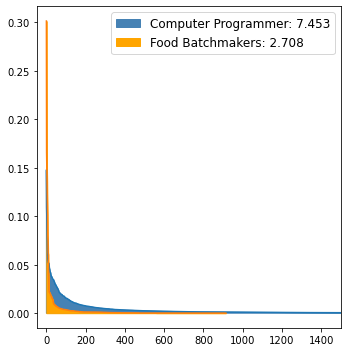

In [143]:
# Figure 1c
fig = plt.figure(figsize=(5,5))

# computer programmer
ax1 = fig.add_subplot(111)
sc=sorted(cc.values(), reverse=True)
plt.plot(sc)
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="Computer Programmer: 7.453")
sb = sorted(bc.values(), reverse=True)
plt.plot(sb)
plt.fill_between(range(len(sb)),sb,0,color="orange", label="Food Batchmakers: 2.708")
plt.legend(fontsize=12)
#plt.ylabel("Skill Probability Change", fontsize=18)
#plt.xlabel("Skills Rank", fontsize=18)
plt.tight_layout()
plt.xlim(-50,1500)
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig1/Fig1P3_wemp_FoodBatchmakers.pdf') 

In [100]:
# change induced by Food Batchmakers new skills: 
scB = {}
for ns in jys[newj][2018]:
    if ns not in jys[newj][2010]:
        # a new job vector without having the focal new skill
        newv = np.mean([model.wv[s] for s in jys[newj][2018] if s in model.wv and s != ns],axis=0)
        # job skill vector change without the presence of the focal new skill
        newc = 1- np.dot(newv, jyv[newj][2010])/(
            np.linalg.norm(newv)* np.linalg.norm(jyv[newj][2010]))
        scB[ns] = abs(jtr[newj] - newc)

In [103]:
# Change induced by Food Batchmakers old(dropped) skills:
soB = {}
newj='Food Batchmakers'
for ns in jys[newj][2010]:
    if ns not in jys[newj][2018]:
        # a new old vector without having the focal old(dropped) skill
        oldv = np.mean([model.wv[s] for s in jys[newj][2010] if s in model.wv and s != ns],axis=0)
        # job skill vector change without the presence of the focal old skill
        newc = 1- np.dot(oldv, jyv[newj][2018])/(
            np.linalg.norm(oldv)* np.linalg.norm(jyv[newj][2018]))
        soB[ns] = abs(jtr[newj] - newc)

In [105]:
# change induced by Computer programmer new skills: 
scC = {}
for ns in jys["Computer Programmers"][2018]:
    if ns not in jys["Computer Programmers"][2010]:
        newv = np.mean([model.wv[s] for s in jys["Computer Programmers"][2018] if s in model.wv and s != ns],axis=0)
        newc = 1- np.dot(newv, jyv["Computer Programmers"][2010])/(
            np.linalg.norm(newv)* np.linalg.norm(jyv["Computer Programmers"][2010]))
        scC[ns] = abs(jtr["Computer Programmers"] - newc)

In [109]:
# change induced by Computer programmer old(dropped) skills: 
soC = {}
for ns in jys["Computer Programmers"][2010]:
    if ns not in jys["Computer Programmers"][2018]:
        oldv = np.mean([model.wv[s] for s in jys["Computer Programmers"][2010] if s in model.wv and s != ns],axis=0)
        newc = 1- np.dot(oldv, jyv["Computer Programmers"][2018])/(
            np.linalg.norm(oldv)* np.linalg.norm(jyv["Computer Programmers"][2018]))
        soC[ns] = abs(jtr["Computer Programmers"] - newc)

In [111]:
sum(scB.values()), sum(scC.values()), sum(soB.values()), sum(soC.values())

(0.050115108489990234,
 0.02186340093612671,
 0.016377389430999756,
 0.005195677280426025)

In [112]:
jtr['Food Batchmakers'], jtr["Computer Programmers"]

(0.08175450563430786, 0.01701796054840088)

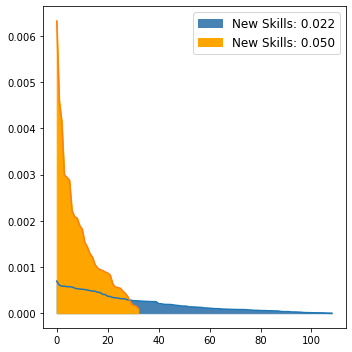

In [144]:
# computer programmer
fig = plt.figure(figsize=(5,5))
#ax1 = fig.add_subplot(111)

sc=sorted(scC.values(), reverse=True)
plt.plot(sc)
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="New Skills: 0.022")
sb = sorted(scB.values(), reverse=True)
plt.plot(sb)
plt.fill_between(range(len(sb)),sb,0,color="orange", label="New Skills: 0.050")
plt.legend(fontsize=12)
#plt.ylabel("Skill Change", fontsize=18)
#plt.xlabel("Core Skills Rank", fontsize=18)
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig1/Fig1P31_new_wemp_foodbatcher.pdf') 

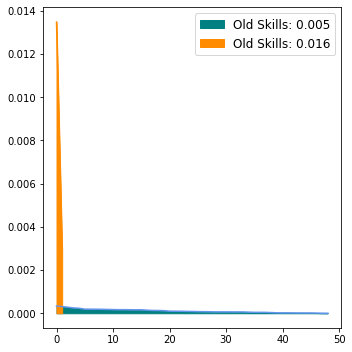

In [149]:
# computer programmer
fig = plt.figure(figsize=(5,5))
#ax1 = fig.add_subplot(111)

sc=sorted(soC.values(), reverse=True)
plt.plot(sc,color="cornflowerblue")
plt.fill_between(range(len(sc)),sc,0,color="teal", label="Old Skills: 0.005")
sb = sorted(soB.values(), reverse=True)
plt.plot(sb,color="darkorange")
plt.fill_between(range(len(sb)),sb,0,color="darkorange", label="Old Skills: 0.016")
plt.legend(fontsize=12)
#plt.ylabel("Skill Change", fontsize=18)
#plt.xlabel("Core Skills Rank", fontsize=18)
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig1/Fig1P32_new_wemp_foodbatcher.pdf') 

### Figure 2

In [57]:
# calculate CI using bootstrap
def calculateCI2(data,method,n, k):
    m=int(len(data)*k) #take 10% data
    ms=[]
    for j in range(n): #number of samples
        if method=='mean':
                ms.append(np.mean(np.random.choice(data,m)))
        if method=='median':
                ms.append(np.median(np.random.choice(data,m)))
    a,b=[np.percentile(ms,2.5),np.percentile(ms,97.5)]
    
    return (b-a)/2

In [58]:
# skill number and job change
# # Deming's measurement
# dfsni = pd.DataFrame(columns=['skill#', "skillchange"])
# for o in osn:
#     if o in occsc80 and o in jtr and o in SOCR:
#         dfsni = dfsni.append({'skill#': osn[o], "skillchange": occsc80[o]}, ignore_index=True)
        
# dfsni['skill#_bins'] = pd.cut(x=dfsni['skill#'], bins=list(range(0, 300, 30)))
# snkeys = [str(k) for k in list(dfsni.groupby(['skill#_bins']).groups.keys())]
# snmeans = list(dfsni.groupby(['skill#_bins'])['skillchange'].mean())
# snstd = list(dfsni.groupby(['skill#_bins'])['skillchange'].apply(calculateCI2, method="mean", n=50,k=0.8))
# xsn_pos = np.arange(len(snkeys))

# job vector change measurement
dfsni_jv = pd.DataFrame(columns=['skill#', "skillchange"])
for o in osn:
    if o in jtr: #o in occsc80_1 and 
        dfsni_jv = dfsni_jv.append({'skill#': osn[o], "skillchange": jtr[o]}, ignore_index=True)
        
dfsni_jv['skill#_bins'] = pd.cut(x=dfsni_jv['skill#'], bins=list(range(0, 90, 10)))
snkeys_jv = [str(k) for k in list(dfsni_jv.groupby(['skill#_bins']).groups.keys())]
xsn_pos = np.arange(len(snkeys_jv))
snmeans_jv = list(dfsni_jv.groupby(['skill#_bins'])['skillchange'].mean())
snstd_jv = list(dfsni_jv.groupby(['skill#_bins'])['skillchange'].apply(calculateCI2, method="mean", n=50,k=0.8))

In [214]:
# edu and job change
ei = defaultdict(lambda:[])
for o in oe:
    if o in jtr:
        if oe[o] < 13:
            ei["high school"].append(jtr[o])
        elif 13 <= oe[o] < 15:
            ei["Associate"].append(jtr[o])
        elif 15 <= oe[o] < 16.5:
            ei["Bachelor"].append(jtr[o])
        else:
            ei["Master/Doctoral"].append(jtr[o])

ekeys = ['high school', 'Associate', 'Bachelor', 'Master/Doctoral']
emeans = [np.mean(ei[key]) for key in ekeys]
estd = [calculateCI2(ei[key],'mean',50, 0.8) for key in ekeys]
xe_pos = np.arange(len(ekeys))

        
# pay
pi = defaultdict(lambda:[])
for o in op:
    if o in jtr:
        if op[o] <= 40000:
            pi["<= 40K"].append(jtr[o])
        elif 40000 <= op[o] < 80000:
            pi["40k-80k"].append(jtr[o])
        else:
            pi[">80k"].append(jtr[o])

pkeys = ['<= 40K', '40k-80k', '>80k']
pmeans = [np.mean(pi[key]) for key in pkeys]
pstd = [calculateCI2(pi[key],'mean',50, 0.8) for key in pkeys]
#pstd = calculateCI2(pi,'mean',50, pkeys, 0.8)
xp_pos = np.arange(len(pkeys))

# edu change and job skill change
eci = defaultdict(lambda:[])
cut1=np.quantile(list(jasec.values()), [1/3])
cut2=np.quantile(list(jasec.values()), [2/3])
for o in jasec:
    if jasec[o] <= cut1:
        eci["1st quantile"].append(jtr[o])
    elif cut1 < jasec[o] <= cut2:
        eci["2nd quantile"].append(jtr[o])
    else:
        eci["3rd quantile"].append(jtr[o])

eckeys = ["1st quantile", "2nd quantile", "3rd quantile"]
ecmeans = [np.mean(eci[key]) for key in eckeys]
ecstd = [calculateCI2(eci[key],'mean',50, 0.8) for key in eckeys]
xec_pos = np.arange(len(eckeys))
print(cut1, cut2)

-0.47992763515462933 1.1166726250158785


In [38]:
# correlation between job education change and job skill change
ec_sc = {}
for o in jasec:
    if o in jtr:
        ec_sc[o] = (jasec[o], jtr[o])
        
x1,y1 = zip(*list(ec_sc.values()))
corr2=pearsonr(x1, y1)
print(corr2)

(0.13503210239982566, 0.00026088300310995874)


In [120]:
# occupation group median stability
gsta = {}
for g in go:
    #gsta[g] = np.median([jtr[j] for j in go[g] if j in jtr and jtr[j] >= gol[g]])
    gsta[g] = np.median([jtr[j] for j in go[g] if j in jtr])

gsta = dict(sorted(gsta.items(), key=operator.itemgetter(1), reverse=True))

df = pd.DataFrame(columns = ["occupation","group", "stability"])
occ=[]
gr=[]
sta=[]
for g in gsta:
    for j in go[g]:
        if j in jtr:
            occ.append(j)
            gr.append(g[:-12])
            sta.append(jtr[j])
        
df["occupation"] = occ
df["group"] = gr
df["stability"] = sta

data=defaultdict(lambda:[])
for i,j in zip(df['group'], df['stability']):
    data[i].append(j) 

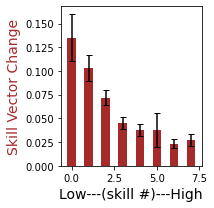

In [136]:
# skill number and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax1 = fig.add_subplot(111)
f3_ax1.bar(xsn_pos, snmeans_jv, width = 0.5, yerr=snstd_jv, color = "brown", align='center', 
           alpha=1, ecolor='black', capsize=3, zorder=10)
f3_ax1.set_ylabel('Skill Vector Change', color = "brown", fontsize=14) 
#f3_ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
f3_ax1.yaxis.set_tick_params(labelsize=10)
f3_ax1.set_xlabel('Low---(skill #)---High', fontsize=14)
#f3_ax1.set_ylim(0, 0.2)
plt.tight_layout()

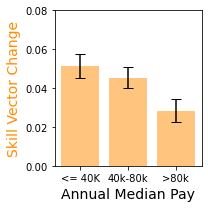

In [133]:
# pay and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax3 = fig.add_subplot(111)
f3_ax3.bar(xp_pos, pmeans, yerr=pstd, color = 'darkorange', align='center', alpha=0.5, ecolor='black', capsize=5)
f3_ax3.set_ylabel('Skill Vector Change', color = 'darkorange', fontsize=14)
f3_ax3.set_xlabel('Annual Median Pay', fontsize=14)
f3_ax3.set_xticks(xp_pos)
f3_ax3.set_xticklabels(pkeys,size=10)
#plt.xticks(rotation=30)
f3_ax3.yaxis.set_tick_params(labelsize=10)
plt.ylim(0,0.08)
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig3/Fig3P2.pdf')

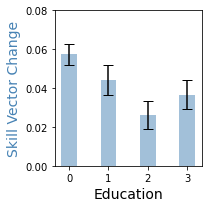

In [145]:
# education and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax2 = fig.add_subplot(111)
f3_ax2.bar(xe_pos, emeans, yerr=estd, width = 0.4, color = 'steelblue', align='center', alpha=0.5, ecolor='black', capsize=5)
f3_ax2.set_ylabel('Skill Vector Change', color = 'steelblue', fontsize=14)
f3_ax2.set_xlabel('Education', fontsize=14)
f3_ax2.set_xticks(xe_pos)
#f3_ax2.set_xticklabels(ekeys, size=10)
f3_ax2.yaxis.set_tick_params(labelsize=10)
#plt.xticks(rotation=30)
plt.ylim(0,0.08)
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig3/Fig3P3.pdf')

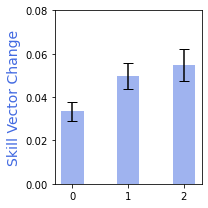

In [146]:
# edu change and job skill change

fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax2 = fig.add_subplot(111)
f3_ax2.bar(xe_pos, emeans, yerr=estd, width = 0.4, color = 'royalblue', align='center', alpha=0.5, ecolor='black', capsize=5)
f3_ax2.set_ylabel('Skill Vector Change', color = 'royalblue', fontsize=14)
#f3_ax2.set_xlabel('Education Change', fontsize=14)
f3_ax2.set_xticks(xe_pos)
#f3_ax2.set_xticklabels(ekeys, size=10)
f3_ax2.yaxis.set_tick_params(labelsize=10)
plt.yticks([0.00, 0.02, 0.04, 0.06, 0.08])
#plt.xticks(rotation=30)
plt.ylim(0,0.08)
plt.tight_layout()

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig3/Fig3P5.pdf')

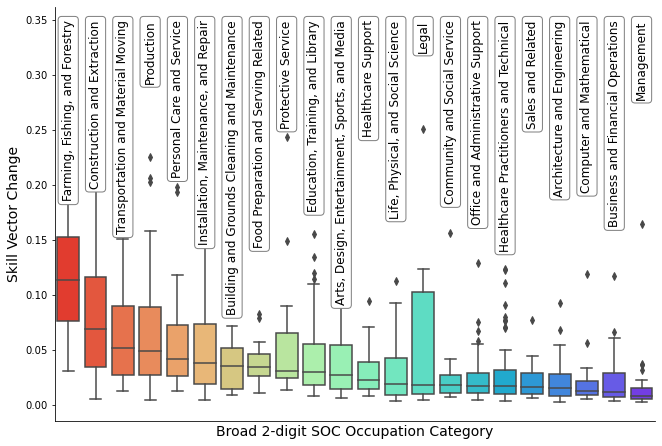

In [147]:
fig = plt.figure(figsize=(9, 6),facecolor='white')

f3_ax4 = fig.add_subplot(111)

f3_ax4= sns.boxplot(y="stability", x="group", data=df, palette="rainbow_r")
#f3_ax4.set_ylim(0,0.2)
#ax.set_title("Job Stability Index",fontsize=22)
f3_ax4.set_ylabel("Skill Vector Change",fontsize=14)
f3_ax4.set_xlabel("Broad 2-digit SOC Occupation Category",fontsize=14)
f3_ax4.set_xticks([])
f3_ax4.yaxis.set_tick_params(labelsize=10)
names= list(data.keys())
for i in range(len(data.keys())):
    #name = " ".join(names[i].split()[:3]) + "\n" + " ".join(names[i].split()[3:])
    name=names[i]
    f3_ax4.text(i, 0.35, name, rotation=90, ha='center', va="top", fontsize=12,
           bbox=dict(boxstyle="round",
                   ec="grey",#(1., 0.5, 0.5),
                   fc='white',
                   ))
sns.despine()
plt.subplots_adjust(hspace=0.0)
plt.tight_layout(pad=0)

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig3/Fig3P4.pdf')

In [ ]:
# if try to combine panels
# fig3 = plt.figure(figsize=(9,9), constrained_layout=True)

# # skill number and job change
# gs = fig3.add_gridspec(3, 3)
# f3_ax1 = fig3.add_subplot(gs[0, 0])
# # paste fig a

# f3_ax2 = fig3.add_subplot(gs[0, 2])
# # paste fig b

# f3_ax3 = fig3.add_subplot(gs[0, 1])
# # paste fig c

# f3_ax4 = fig3.add_subplot(gs[1:, :])
# # paste fig d

### Figure 3

In [8]:
# location - job - post number
Year2018a={}
with open('/Users/ditong/Dropbox (MIT)/BG/BG/year_area_job.txt','r') as f:
    for line in f:
        line=line.strip().split('\t')
        year=int(line[0])
        if year ==2018: 
            lat=float(line[1])
            lon=float(line[2])
            v=[i.split('_') for i in line[3:]]
            dic={i:int(j) for i,j in v if i!='na'}
            Year2018a[(lat,lon)]=dic
            
# ground location to 1 digit: location - job - post number
Year2018=defaultdict(lambda:defaultdict(lambda:0))
for loc in Year2018a:
    newloc=(round(loc[0],1), round(loc[1],1))
    for j in Year2018a[loc]:
        Year2018[newloc][j] += Year2018a[loc][j]
        
# 1 digit location - sum post size (job market size)
locsize18=defaultdict(lambda:0)
with open('/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/year_loc1_size.txt', 'r') as f1:
    for line in f1:
        linelst=line.split("\t")
        year=int(linelst[0])
        locs=linelst[1].split("_")
        size=int(linelst[2])
        if year==2018:
            locsize18[float(locs[1]), float(locs[0])]=size
            
len(Year2018), len(Year2018a), np.percentile(list(locsize18.values()), [90])[0]

(25643, 45541, 1040.7999999999993)

In [154]:
# skill change score for each location
Cscore={}
n=0
SizePerc90=round(np.percentile(list(locsize18.values()), [90])[0])
for town in Year2018:
    n+=1
    if n%100==0:
        flushPrint(n/100)
    if town in locsize18:
        # get rid of outliers
        if 100 < locsize18[town]: #100 < < 10000:
            # use different dictionary for different location
            if locsize18[town]>SizePerc90:
                dic=llocjtr
            else:
                dic=slocjtr
            # more than three jobs per town
            if len(Year2018[town])>=3:
                jp=defaultdict(lambda:0)
                for j in Year2018[town]:
                    if j in dic:
                        jp[j]+=Year2018[town][j]
                s=sum([v for v in jp.values()])
                jp=dict((k,v/s) for k,v in jp.items())
                c_score=sum([dic[i]*jp[i] for i in jp])
                Cscore[town]=c_score

256

In [155]:
lats, lons = zip(*list(Cscore.keys()))
chas = list(Cscore.values())
latloncha = {'latitude': lats, 'longitude': lons, 'change': chas}
latloncha_df=pd.DataFrame(data=latloncha)
#latloncha_df.to_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/LatLonChange.csv')
len(Cscore)

8951

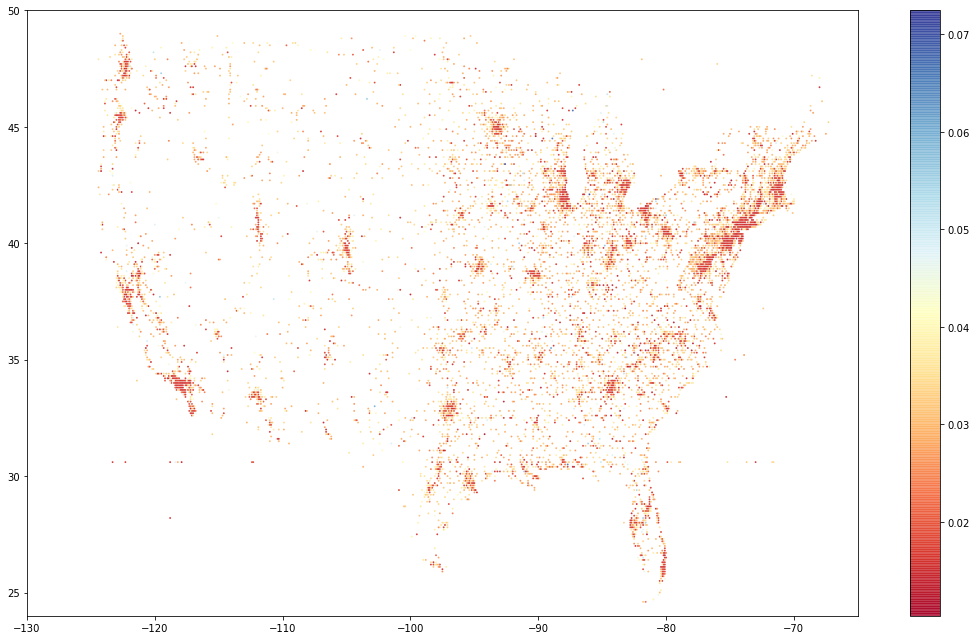

In [162]:
# lat,lon=zip(*list(Cscore.keys()))
# score=list(Cscore.values())

# fig = plt.figure(figsize=(15, 9))
# ax = fig.add_subplot(111)
# cm = plt.cm.get_cmap('RdYlBu')
# scatters=plt.scatter(lat,lon,c=score,s=0.8,alpha=.8,cmap=cm)
# #plt.clim(0.01, 0.065)
# plt.colorbar(scatters)
# plt.xlim(-130,-65)
# plt.ylim(24,50)
# plt.tight_layout()
# #plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig4/Fig4P1.pdf')
# plt.show()

In [16]:
# us state geometry data
states = geopandas.read_file(
    '/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/usmap/usa-states-census-2014.shp')

statematch = []
for lat, lon in zip(latloncha_df['latitude'], latloncha_df['longitude']):
    p1 = Point(map(float, (lat, lon)))
    k=states[states['geometry'].contains(p1)]['NAME']
    try:
        statematch.append(k[k.index[0]])
    except:
        print(k)
        statematch.append(float('nan'))
        
latloncha_df['NAME'] = statematch
latloncha_df=latloncha_df.dropna()
len(latloncha_df)

Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], N

Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], N

8673

In [19]:
statecha = latloncha_df.drop(columns=['latitude', 'longitude'])
statecha = statecha.groupby('NAME').mean().reset_index()
states_wcha = states.merge(statecha, how='inner', on='NAME')
states_wcha = states_wcha.drop_duplicates(['NAME'])

len(states_wcha), len(states), len(statecha)

(49, 58, 49)

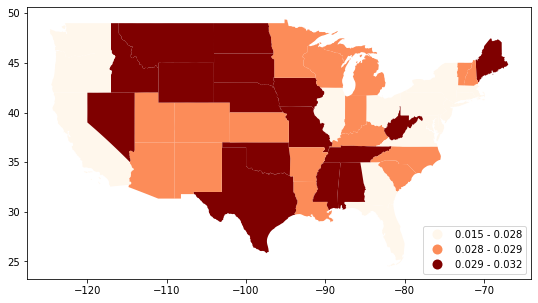

In [22]:
# state - average job skill change in three quantiles
fig, ax = plt.subplots(1, 1,figsize=(10, 5))

states_wcha.plot(column='change',
           ax=ax,
           legend=True,
            cmap='OrRd',
            figsize=(20, 20),
            scheme='quantiles',
            k=3,
            legend_kwds={'loc': 'lower right'}
            )

# get all upper bounds
upper_bounds = mapclassify.Quantiles(states_wcha.change, k=3).bins

# get and format all bounds
bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = states_wcha.change.min()
    else:
        lower_bound = upper_bounds[index-1]

    # format the numerical legend here
    bound = f'{lower_bound:.3f} - {upper_bound:.3f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig4/Fig4P1_v2state.pdf')

In [24]:
# us county geometry data
geoData = geopandas.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)
# drop alaska, hawaii and puerto rico
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

len(geoData)

3109

In [27]:
Countymatch = []
for lat, lon in zip(latloncha_df['latitude'], latloncha_df['longitude']):
    p1 = Point(map(float, (lat, lon)))
    k=geoData[geoData['geometry'].contains(p1)]['NAME']
    try:
        Countymatch.append(k[k.index[0]])
    except:
        print(k)
        Countymatch.append(float('nan'))
        
latloncha_df['NAME'] = Countymatch
latloncha_df=latloncha_df.dropna()
len(latloncha_df)

Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], Name: NAME, dtype: object)
Series([], N

/Users/ditong/anaconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


8638

In [29]:
countycha = latloncha_df.drop(columns=['latitude', 'longitude'])
countycha = countycha.groupby('NAME').mean().reset_index()
county_wcha = geoData.merge(countycha, how='inner', on='NAME')
county_wcha = county_wcha.drop_duplicates(['NAME'])
len(county_wcha), len(geoData), len(countycha)

(1574, 3109, 1574)

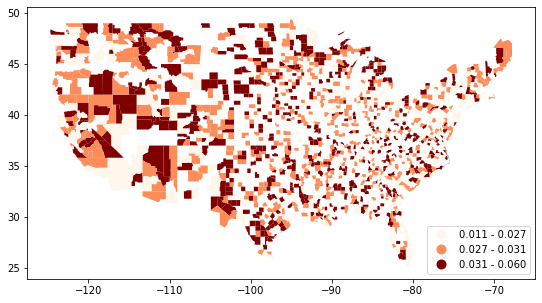

In [30]:
fig, ax = plt.subplots(1, 1,figsize=(10, 5))

county_wcha.plot(column='change',
           ax=ax,
           legend=True,
            cmap='OrRd',
            figsize=(20, 20),
            scheme='quantiles',
            k=3,
            legend_kwds={'loc': 'lower right'}
                )

# get all upper bounds
upper_bounds = mapclassify.Quantiles(county_wcha.change, k=3).bins

# get and format all bounds
bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = county_wcha.change.min()
    else:
        lower_bound = upper_bounds[index-1]

    # format the numerical legend here
    bound = f'{lower_bound:.3f} - {upper_bound:.3f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)
    
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig4/Fig4P1_v2county.pdf')

In [148]:
# read in social group data
GenderRace=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/2018_race_gender.xlsx').dropna().reset_index()


# gender by race probability for the entire workforce
bl={}
bl["white women"] = GenderRace.iloc[0]['Women'] * GenderRace.iloc[0]['White']/10000
bl["white men"] = (100-GenderRace.iloc[0]['Women']) * GenderRace.iloc[0]['White']/10000
bl["black women"] = GenderRace.iloc[0]['Women'] * GenderRace.iloc[0]['Black or\nAfrican\nAmerican']/10000
bl["black men"] = (100-GenderRace.iloc[0]['Women']) * GenderRace.iloc[0]['Black or\nAfrican\nAmerican']/10000
bl["asian women"] = GenderRace.iloc[0]['Women'] * GenderRace.iloc[0]['Asian']/10000
bl["asian men"] = (100-GenderRace.iloc[0]['Women']) * GenderRace.iloc[0]['Asian']/10000
bl["latinx women"] = GenderRace.iloc[0]['Women'] * GenderRace.iloc[0]['Hispanic\nor Latino']/10000
bl["latinx men"] = (100-GenderRace.iloc[0]['Women']) * GenderRace.iloc[0]['Hispanic\nor Latino']/10000


# all job names to loweer case for matching
osn2= dict([(j.lower(), osn[j]) for j in osn])
jtr2=dict([(j.lower(), jtr[j]) for j in jtr])
js = [o for o in osn2 if o in jtr2]
op2= dict([(j.lower(), op[j]) for j in op])
oe2= dict([(j.lower(), oe[j]) for j in oe])
GenderRace['occupation'] = [occ.lower() for occ in GenderRace['occupation'] ]
GenderRace = GenderRace[GenderRace['occupation'].isin(js)]
# Remove NAs
GenderRace = GenderRace[(GenderRace['Women']!='–') & (GenderRace['White']!='–') & (
                            GenderRace['Hispanic\nor Latino']!='–')]


# actual gender by race probability for each occupation
occgp=defaultdict(lambda:defaultdict(lambda:0))
for a,b,c,d,e,f in zip(GenderRace['occupation'], GenderRace['Women'],GenderRace['White'],
                    GenderRace['Black or\nAfrican\nAmerican'], GenderRace['Asian'], GenderRace['Hispanic\nor Latino']):
    occgp['white women'][a]=b*c/10000
    occgp['white men'][a]=(100-b)*c/10000
    occgp['black women'][a]=b*d/10000
    occgp['black men'][a]=(100-b)*d/10000
    occgp['asian women'][a]=b*e/10000
    occgp['asian men'][a]=(100-b)*e/10000
    occgp['latinx women'][a]=b*f/10000
    occgp['latinx men'][a]=(100-b)*f/10000
    
# classify occupations to each race-gender group
occpar=defaultdict(lambda:[])
occgp=defaultdict(lambda:defaultdict(lambda:0))
k=1.5
for a,b,c,d,e,f in zip(GenderRace['occupation'], GenderRace['Women'],GenderRace['White'],
                    GenderRace['Black or\nAfrican\nAmerican'], GenderRace['Asian'], GenderRace['Hispanic\nor Latino']):
    if b*c/10000 > k*bl['white women']:
        occpar['white women'].append(a)
        occgp[a]['white women']=b*c/10000
    if (100-b)*c/10000 > k*bl['white men']:
        occpar['white men'].append(a)
        occgp[a]['white men']=(100-b)*c/10000
    if b*d/10000 > k*bl['black women']:
        occpar['black women'].append(a)
        occgp[a]['black women']=b*d/10000
    if (100-b)*d/10000 > k*bl['black men']:
        occpar['black men'].append(a)
        occgp[a]['black men']=(100-b)*d/10000
    if b*e/10000 > k*bl['asian women']:
        occpar['asian women'].append(a)
        occgp[a]['asian women']=b*e/10000
    if (100-b)*e/10000 > k*bl['asian men']:
        occpar['asian men'].append(a)
        occgp[a]['asian men']=(100-b)*e/10000
    if b*f/10000 > k*bl['latinx women']:
        occpar['latinx women'].append(a)
        occgp[a]['latinx women']=b*f/10000
    if (100-b)*f/10000 > k*bl['latinx men']:
        occpar['latinx men'].append(a)
        occgp[a]['latinx men']=(100-b)*f/10000
        
        
# add skill change and skill number
GenderRace=GenderRace[['occupation', 'Women', 'White', 'Hispanic\nor Latino']]
GenderRace['skill#'] = [osn2[j] for j in GenderRace['occupation']]
GenderRace['skillchange'] = [jtr2[j] for j in GenderRace['occupation']]

len(GenderRace)

226

In [149]:
# classify occupations into binary groups
def classify(row, var, thresh):
    if var == 'White':
        if row[var] <= thresh:
            return 1
        else:
            return 0 
    else:
        if row[var] > thresh:
            return 1
        else:
            return 0
    
GenderRace['female']=GenderRace.apply (lambda row: classify(row, 'Women', 50), axis=1)
meanwhite=np.mean(GenderRace['White'])
GenderRace['nonwhite']=GenderRace.apply (lambda row: classify(row, 'White', meanwhite), axis=1)
meanhis=np.mean(GenderRace['Hispanic\nor Latino'])
GenderRace['hispanic']=GenderRace.apply (lambda row: classify(row, 'Hispanic\nor Latino', meanhis), axis=1)

In [150]:
# GET THE percentile group of a number in a list
def perc_group(x,n, skills):
    return np.ceil(stats.percentileofscore(skills, x)/n)

# skill number bins
GenderRace['skill#_bins'] = pd.cut(x=GenderRace['skill#'], bins=list(range(0, 550, 50)))
# same volume data bins
GenderRace['skill#perc_bins']=GenderRace['skill#'].apply(perc_group, n=10, skills=list(GenderRace['skill#']))

In [151]:
# skill number and small-large company job vector change 
lscomp = pd.DataFrame(columns=['skill#'])
for o in osn:
    if o in lcjtr and o in scjtr:
        lscomp = lscomp.append({'skill#': osn[o], "Lskillchange": lcjtr[o], 
                                      "Sskillchange": scjtr[o]}, ignore_index=True)
        
lscomp['skill#_bins'] = pd.cut(x=lscomp['skill#'], bins=list(range(0, 550, 50)))
lscomp['skill#perc_bins']=lscomp['skill#'].apply(perc_group,n=10, skills=list(lscomp['skill#']))

# skill number and small-large location job vector change 
lsloc = pd.DataFrame(columns=['skill#'])
for o in osn:
    if o in llocjtr and o in slocjtr:
        lsloc = lsloc.append({'skill#': osn[o], "Lskillchange": llocjtr[o], 
                                      "Sskillchange": slocjtr[o]}, ignore_index=True)
        
lsloc['skill#_bins'] = pd.cut(x=lsloc['skill#'], bins=list(range(0, 550, 50)))
lsloc['skill#perc_bins']=lsloc['skill#'].apply(perc_group, n=10, skills=list(lsloc['skill#']))

In [152]:
# skill number and XXX job vector change difference
def plot(GenderRaceAge, var, gs, x, y, label, color, binname, ylimhi):
    
    if var not in ['large company', 'large market size', 'large market size among large company',
                  'large market size among small company']:
        adf = GenderRaceAge[GenderRaceAge[var]==1]
        bdf = GenderRaceAge[GenderRaceAge[var]==0]
        means = np.array(adf.groupby([binname])['skillchange'].mean()) - np.array(
            bdf.groupby([binname])['skillchange'].mean())
        
    else:
        means = np.array(GenderRaceAge.groupby([binname])['Sskillchange'].mean()) - np.array(
            GenderRaceAge.groupby([binname])['Lskillchange'].mean())

    dele=[]
    for i in range(len(means)):
        if np.isnan(means[i]):
            dele.append(i)

    keys = [str(k) for k in list(GenderRaceAge.groupby([binname]).groups.keys())]
    for i in sorted(dele, reverse=True):
        del keys[i]

    means = means[~np.isnan(means)]

    #snstd_jv = list(df_sndiff.groupby(['skill#_bins'])['skillchangediff'].apply(calculateCI2, method="mean", n=50,k=0.8))

    pos = np.arange(len(keys))
    if gs == 'none':
        f3_ax1 = fig3.add_subplot(111)
    else:
        f3_ax1 = fig3.add_subplot(gs[x, y])
    f3_ax1.bar(pos, means, width = 0.5, color = color, align='center', 
               alpha=1, ecolor='black', capsize=3, tick_label=keys, zorder=10)
    f3_ax1.set_ylabel('Relative job skill change', fontsize=14) 

    f3_ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
    f3_ax1.yaxis.set_tick_params(labelsize=10)
    f3_ax1.set_xlabel('Low-(skill # percentile)-High', fontsize=14)
    f3_ax1.set_title(label, fontsize=14)
    plt.axhline(y=0, color='black')
    plt.ylim(0,ylimhi)

<ipython-input-159-846a94a1ec08>:7: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


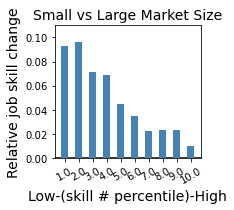

In [159]:
fig3 = plt.figure(figsize=(3,3), constrained_layout=True)


# skill number and job change
gs = 'none'
plot(lsloc, 'large market size', gs, 0, 3, "Small vs Large Market Size", "steelblue", "skill#perc_bins", 0.11)
plt.tight_layout()

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig4/Fig4P2.pdf')

<ipython-input-160-514008202409>:7: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


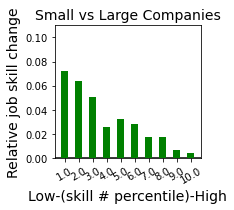

In [160]:
fig3 = plt.figure(figsize=(3,3), constrained_layout=True)


# skill number and job change
gs = 'none'
plot(lscomp, 'large company', gs, 1, 3, "Small vs Large Companies", "green", "skill#perc_bins", 0.11)
plt.tight_layout()

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig4/Fig4P3.pdf')


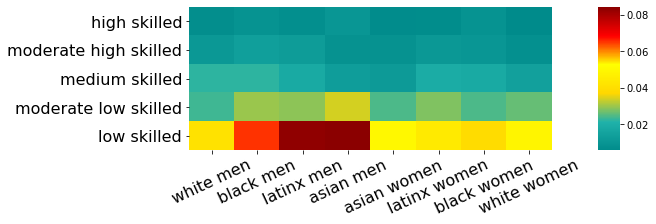

In [161]:
# average job skill change for each race gender group by skill level
df_rg=pd.DataFrame()
gjc=defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for cat in ['white men', 'black men', 'latinx men', 'asian men', 'asian women', 'latinx women',
            'black women', 'white women']:
    wwjs=occpar[cat]
    wwgjc=defaultdict(lambda:defaultdict(lambda:0))
    for o in wwjs:
        if o in osn2 and o in jtr2:
            perc = np.ceil(stats.percentileofscore(list(GenderRace['skill#']), osn2[o])/20)
            wwgjc[perc][o]=jtr2[o]
    wwgjc = dict(sorted(wwgjc.items(), key=operator.itemgetter(0), reverse=True))
    gjc[cat]=wwgjc
    df_rg[cat] = [np.median(list(wwgjc[g].values())) for g in list(range(1,6))][::-1]

cmap= matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkcyan",'lightseagreen',"gold",'yellow',"red","darkred"])
#f3_ax2 = fig3.add_subplot(gs[2, :3])
fig3 = plt.figure(figsize=(9,3), constrained_layout=True)
y_axis_labels = ['high skilled', 'moderate high skilled', 'medium skilled', 'moderate low skilled', 'low skilled']
ax = sns.heatmap(df_rg, cbar=True, cmap=cmap, yticklabels=y_axis_labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
plt.show()

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig4/Fig4P4.pdf')

<ipython-input-164-5d801b590b16>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


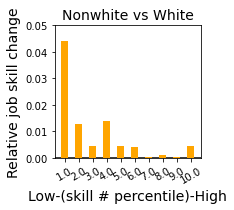

In [164]:
# fig3 = plt.figure(figsize=(3,3), constrained_layout=True)


# # skill number and job change
# gs = 'none'
# t=0.05
# plot(GenderRace, 'nonwhite', gs, 2, 3, "Nonwhite vs White", "orange", "skill#perc_bins", t)
# plt.tight_layout()

# plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig4/Fig4P5.pdf')

In [ ]:
# fig3 = plt.figure(figsize=(10,12), constrained_layout=True)


# # skill number and job change
# gs = fig3.add_gridspec(3, 2)
# plot(lsloc, 'large market size', gs, 0, 1, "Small vs Large Market Size", "steelblue", "skill#perc_bins", 0.11)
# plot(lscomp, 'large company', gs, 0, 0, "Small vs Large Companies", "green", "skill#perc_bins", 0.11)
# plot(lsloclcomp, 'large market size among large company', gs, 1, 0, "Small vs Large Market, Large Company", 
#      "royalblue", "skill#perc_bins", 0.11)
# plot(lslocscomp, 'large market size among small company', gs, 1, 1, "Small vs Large Market, Small Company", 
#      "coral", "skill#perc_bins", 0.11)
# plot(lslloccomp, 'large market size among large company', gs, 2, 0, "Small vs Large Companies, Large Market", 
#      "purple", "skill#perc_bins", 0.11)
# plot(lssloccomp, 'large market size among small company', gs, 2, 1, "Small vs Large Companies, Small Market", 
#      "pink", "skill#perc_bins", 0.11)

### Figure 4

In [165]:
infile = open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/atom_model/200d_210comp5nonzeros_dictionary_nvdrsdf20','rb')
dictionary=pickle.load(infile)
infile.close()

infile = open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/atom_model/200d_210comp5nonzeros_aksvd_nvdrsdf20','rb')
aksvd=pickle.load(infile)
infile.close()

infile = open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/atom_model/200d_210comp5nonzeros_alpha_nvdrsdf20','rb')
alpha=pickle.load(infile)
infile.close()

In [167]:
# job-year-array of weights
# allskills=list(model.wv.vocab)
# jyw=defaultdict(lambda:defaultdict(lambda:np.array([])))
# for job in jys:
#     if 2010 in jys[job] and 2018 in jys[job]:
#         aw = np.zeros(shape=(1,210))
#         for s in jys[job][2010]:
#             if s in allskills:
#                 aw = aw + np.array(alpha[model.wv.vocab[s].index])
#         jyw[job][2010] = aw[0] / sum(aw[0])
#         for s in jys[job][2018]:
#             if s in allskills:
#                 aw = aw + np.array(alpha[model.wv.vocab[s].index])
#         jyw[job][2018] = aw[0] / sum(aw[0])  
        
# job-year-array of weights
allskills=list(model.wv.index_to_key)
jyw=defaultdict(lambda:defaultdict(lambda:np.array([])))
for job in jys:
    if 2010 in jys[job] and 2018 in jys[job]:
        aw = np.zeros(shape=(1,210))
        for s in jys[job][2010]:
            if s in allskills:
                aw = aw + np.array(alpha[model.wv.key_to_index[s]])
        jyw[job][2010] = aw[0] / sum(aw[0])
        for s in jys[job][2018]:
            if s in allskills:
                aw = aw + np.array(alpha[model.wv.key_to_index[s]])
        jyw[job][2018] = aw[0] / sum(aw[0])  

In [168]:
# job-year-atom-weight
jyaw = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
yajw = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for job in jyw:
    for year in jyw[job]:
        order = np.argsort(jyw[job][year])[::-1]
        for ind in order:
            jyaw[job][year][ind] = jyw[job][year][ind]
            yajw[year][ind][job] = jyw[job][year][ind]

In [14]:
# yaw=defaultdict(lambda:defaultdict(lambda:0))
# for yr in yajw:
#     for a in yajw[yr]:
#         yaw[yr][a] = np.mean(list(yajw[yr][a].values()))
#     yaw[yr]=dict(sorted(yaw[yr].items(), key=operator.itemgetter(1), reverse=True))

In [169]:
# job-atom weight change
jawd = defaultdict(lambda:defaultdict(lambda:0))
ajwd = defaultdict(lambda:defaultdict(lambda:0))
for job in jyw:
    diff = jyw[job][2018] - jyw[job][2010]
    order = np.argsort(diff)[::-1]
    for ind in order:
        idiff = jyw[job][2018][ind] - jyw[job][2010][ind]
        jawd[job][ind] = idiff
        ajwd[ind][job] = idiff

In [170]:
ad = {}
for a in ajwd:
    ad[a] = sum(ajwd[a].values())
ad = dict(sorted(ad.items(), key=lambda item: item[1], reverse=True))

In [171]:
# obstain 2D coordinates by embedding 
coordsTSNE = TSNE(n_components=2, random_state=0).fit_transform(dictionary)

# skill-2D vector
atv={}
for i in range(210):
    atv[i] = coordsTSNE[i]

In [149]:
# with open ("/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/atom_2dloc.txt", 'w') as f:
#     for a in atv:
#         line = "\t".join([str(a), str(atv[a][0]), str(atv[a][1])])
#         f.write(line+"\n")  

In [172]:
# read in 2d locations
atv={}
with open ("/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/atom_2dloc.txt", 'r') as f:
    for line in f:
        line_lst=line.split("\t")
        atv[int(line_lst[0])] = (float(line_lst[1]), float(line_lst[2]))

In [173]:
# read in labels: machine/human
atlabel = pd.read_csv("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/atom_labeling.csv")
cola = {}
cola['cornflowerblue'] = 'machine'
cola['orange'] = 'human'

acol = {}
for i, row in atlabel.iterrows():
    if row['machine'] == 0: #or row['machine'] == 2:
        acol[row['index']] = 'orange'
    else:
        acol[row['index']] = 'cornflowerblue'

In [174]:
len(atv), len(acol)

(210, 210)

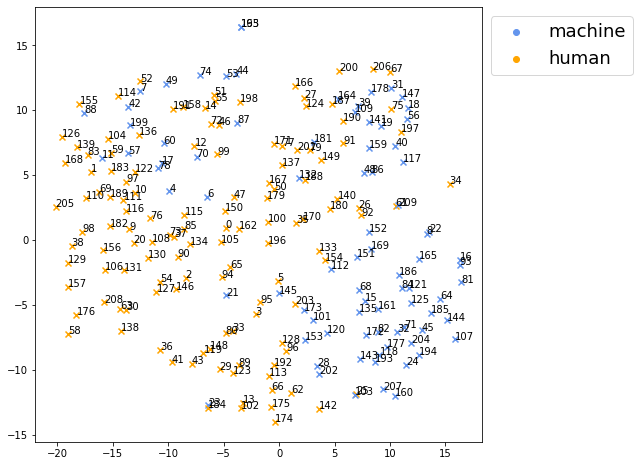

In [175]:
# original 2d positions
fig = plt.figure(figsize=(8, 8),facecolor='white')
ax = fig.add_subplot(111)
for at in atv:
    x,y = atv[at]
    plt.scatter(x,y,color=acol[at],marker='x')
    plt.annotate(str(at), (x, y))
            
for col in cola:
    plt.scatter([],[], color=col, label=cola[col])
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=18)

In [176]:
# get the boundaries of all locations
xl=50
xr=-50
yu=-50
yd=50
for a in atv:
    x,y=atv[a]
    if x<xl:
        xl=x
    if x>xr:
        xr=x
    if y<yd:
        yd=y
    if y>yu:
        yu=y

xl,xr,yu,yd

(-20.169127, 16.451687, 16.429686, -14.035293)

In [177]:
# set up gridspace
gridx=np.linspace(xl, xr, num=15)
gridy=np.linspace(yd, yu, num=14)
gridloc=[]
for x in gridx:
    for y in gridy:
        gridloc.append((x,y))
len(gridx), len(gridy), len(gridloc)

(15, 14, 210)

In [178]:
# calculate the distance from each atom to each grid node
agdis = defaultdict(lambda:defaultdict(lambda:0))
for a in atv:
    for loc in gridloc:
        agdis[a][loc]=math.sqrt((loc[0]-atv[a][0])**2+(loc[1]-atv[a][1])**2)

In [179]:
# for each grid node, assign nearest atom to it
agdis2=copy.deepcopy(agdis)
locadis={}
aloc={}
for loc in gridloc:
    dis=10000
    at=''
    for a in agdis2:
        if agdis2[a][loc] < dis:
            dis = agdis2[a][loc]
            at=a
    locadis[loc]=(at, dis)
    aloc[at]=loc
    if at != '':
        del(agdis2[at])

In [86]:
# gi={}
# gi[65]="warehouse and shipping"
# #gi[105]="catering"
# gi[62]="store merchandising"
# #gi[0]="emergency handling"
# #gi[34]="banking service"
# gi[121]="cloud computing"
# gi[77]="environment"
# gi[94]="office skills"
# gi[48]="advanced manufacuturing"
# gi[180]='freight handling'
# gi[18]='welding and bending'
# #gi[40]='chemical industry'
# di={}
# di[73]='medical records'
# di[156]="massage"
# di[89]='mortgage loan servicing'
# di[56]="construction and installation"
# di[75]="repair and maintenance"
# di[3]="language and translation"
# di[5]="tutoring"
# di[36]="stakeholder management"
#di[113]="sales"
#di[13]="investment and assest"

In [167]:
# divide by education
# jawdle = defaultdict(lambda:defaultdict(lambda:0))
# ajwdle = defaultdict(lambda:defaultdict(lambda:0))
# jawdhe = defaultdict(lambda:defaultdict(lambda:0))
# ajwdhe = defaultdict(lambda:defaultdict(lambda:0))
# for job in jyw:
#     if job in oe:
#         if round(oe[job]) < 16:
#             diff = jyw[job][2018] - jyw[job][2010]
#             order = np.argsort(diff)[::-1]
#             for ind in order:
#                 idiff = jyw[job][2018][ind] - jyw[job][2010][ind]
#                 jawdle[job][ind] = idiff
#                 ajwdle[ind][job] = idiff
#         elif round(oe[job]) >= 16:
#             diff = jyw[job][2018] - jyw[job][2010]
#             order = np.argsort(diff)[::-1]
#             for ind in order:
#                 idiff = jyw[job][2018][ind] - jyw[job][2010][ind]
#                 jawdhe[job][ind] = idiff
#                 ajwdhe[ind][job] = idiff

In [168]:
# low and high education
# adle = {}
# for a in ajwdle:
#     adle[a] = sum(ajwdle[a].values())
# adle = dict(sorted(adle.items(), key=lambda item: item[1], reverse=True))

# adhe = {}
# for a in ajwdhe:
#     adhe[a] = sum(ajwdhe[a].values())
# adhe = dict(sorted(adhe.items(), key=lambda item: item[1], reverse=True))

Text(0.5, 1.0, 'decreasing importance, mid education')

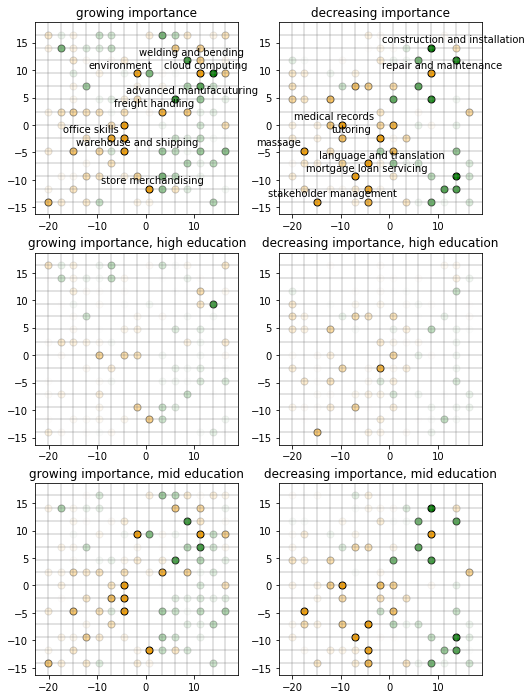

In [169]:
# k=1
# fig = plt.figure(figsize=(8, 12),facecolor='white')

# ax = fig.add_subplot(321)
# for x in gridx:
#     plt.axvline(x=x, color='grey',alpha=0.3)
# for y in gridy:
#     plt.axhline(y=y, color='grey',alpha=0.3)
# for loc in locadis:
#     at=locadis[loc][0]
#     if at != '':
#         alp=ad[at]
#         if alp>0:
#             plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1),edgecolor='black', s=50)
#         if at in gi:
#             plt.text(loc[0]-10, loc[1]+1, gi[at])
# plt.title("growing importance")

# ax = fig.add_subplot(322)
# for x in gridx:
#     plt.axvline(x=x, color='grey',alpha=0.3)
# for y in gridy:
#     plt.axhline(y=y, color='grey',alpha=0.3)
# for loc in locadis:
#     at=locadis[loc][0]
#     if at != '':
#         alp=ad[at]
#         if alp<0:
#             plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(abs(alp*k),1),edgecolor='black', s=50)
#         if at in di:
#             plt.text(loc[0]-10, loc[1]+1, di[at])
# plt.title("decreasing importance")

# ax = fig.add_subplot(323)
# for x in gridx:
#     plt.axvline(x=x, color='grey',alpha=0.3)
# for y in gridy:
#     plt.axhline(y=y, color='grey',alpha=0.3)
# for loc in locadis:
#     at=locadis[loc][0]
#     if at != '':
#         alp=adhe[at]
#         if alp>0:
#             plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1),edgecolor='black', s=50)
# #         if at in gi:
# #             plt.text(loc[0]-10, loc[1]+1, gi[at])
# plt.title("growing importance, high education")

# ax = fig.add_subplot(324)
# for x in gridx:
#     plt.axvline(x=x, color='grey',alpha=0.3)
# for y in gridy:
#     plt.axhline(y=y, color='grey',alpha=0.3)
# for loc in locadis:
#     at=locadis[loc][0]
#     if at != '':
#         alp=adhe[at]
#         if alp<0:
#             plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(abs(alp*k),1),edgecolor='black', s=50)
# #         if at in di:
# #             plt.text(loc[0]-10, loc[1]+1, di[at])
# plt.title("decreasing importance, high education")

# ax = fig.add_subplot(325)
# for x in gridx:
#     plt.axvline(x=x, color='grey',alpha=0.3)
# for y in gridy:
#     plt.axhline(y=y, color='grey',alpha=0.3)
# for loc in locadis:
#     at=locadis[loc][0]
#     if at != '':
#         alp=adle[at]
#         if alp>0:
#             plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1),edgecolor='black', s=50)
# #         if at in gi:
# #             plt.text(loc[0]-10, loc[1]+1, gi[at])
# plt.title("growing importance, mid education")

# ax = fig.add_subplot(326)
# for x in gridx:
#     plt.axvline(x=x, color='grey',alpha=0.3)
# for y in gridy:
#     plt.axhline(y=y, color='grey',alpha=0.3)
# for loc in locadis:
#     at=locadis[loc][0]
#     if at != '':
#         alp=adle[at]
#         if alp<0:
#             plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(abs(alp*k),1),edgecolor='black', s=50)
# #         if at in di:
# #             plt.text(loc[0]-10, loc[1]+1, di[at])
# plt.title("decreasing importance, mid education")

In [175]:
# def illustrate_occupation(j1, j2, k, dic):

#     fig = plt.figure(figsize=(8, 8),facecolor='white')
#     ax = fig.add_subplot(221)
#     for x in gridx:
#         plt.axvline(x=x, color='grey',alpha=0.3)
#     for y in gridy:
#         plt.axhline(y=y, color='grey',alpha=0.3)
#     for loc in locadis:
#         at=locadis[loc][0]
#         if at != '':
#             alp=dic[j1][2010][at]
#             if alp>0:
#                 plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1),edgecolor='black', s=50)
#     plt.title(j1+", 2010", fontsize=14)

#     ax = fig.add_subplot(222)
#     for x in gridx:
#         plt.axvline(x=x, color='grey',alpha=0.3)
#     for y in gridy:
#         plt.axhline(y=y, color='grey',alpha=0.3)
#     for loc in locadis:
#         at=locadis[loc][0]
#         if at != '':
#             alp=dic[j1][2018][at]
#             if alp>0:
#                 plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1),edgecolor='black', s=50)
#     plt.title(j1+", 2018", fontsize=14)

#     ax = fig.add_subplot(223)
#     for x in gridx:
#         plt.axvline(x=x, color='grey',alpha=0.3)
#     for y in gridy:
#         plt.axhline(y=y, color='grey',alpha=0.3)
#     for loc in locadis:
#         at=locadis[loc][0]
#         if at != '':
#             alp=dic[j2][2010][at]
#             if alp>0:
#                 plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1),edgecolor='black', s=50)
#     plt.title(j2+", 2010", fontsize=12)

#     ax = fig.add_subplot(224)
#     for x in gridx:
#         plt.axvline(x=x, color='grey',alpha=0.3)
#     for y in gridy:
#         plt.axhline(y=y, color='grey',alpha=0.3)
#     for loc in locadis:
#         at=locadis[loc][0]
#         if at != '':
#             alp=dic[j2][2018][at]
#             if alp>0:
#                 plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1),edgecolor='black', s=50)
#     plt.title(j2+", 2018", fontsize=12)

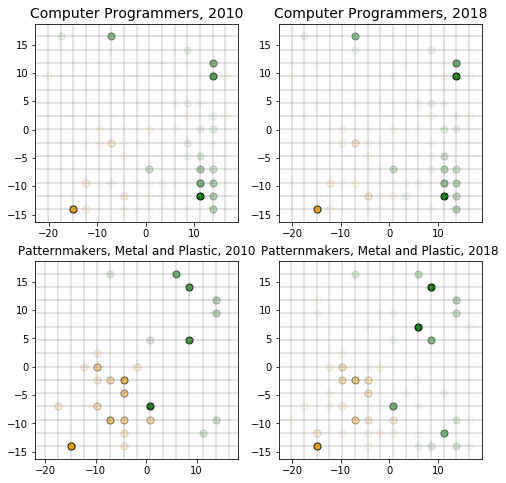

In [176]:
# illustrate_occupation('Computer Programmers', 'Patternmakers, Metal and Plastic', 10, jyaw)

In [180]:
# gi={}
# gi[65]="warehouse and shipping"
# #gi[105]="catering"
# gi[62]="store merchandising"
# #gi[0]="emergency handling"
# #gi[34]="banking service"
# gi[121]="cloud computing"
# gi[77]="environment"
# gi[94]="office skills"
# gi[48]="advanced manufacuturing"
# gi[180]='freight handling'
# gi[18]='welding and bending'
# #gi[40]='chemical industry'
# gi[82]='big data processing'
# gi[202]='web analytics'
# gi[89]='mortgage'
# gi[8]='control system software'

# di={}
# di[73]='medical records'
# di[156]="massage"
# di[89]='mortgage loan servicing'
# di[56]="construction and installation"
# di[75]="repair and maintenance"
# di[3]="language and translation"
# di[5]="tutoring"
# di[36]="stakeholder management"
# #di[113]="sales"
# #di[13]="investment and assest"
# di[105]="hospitality industry knowledge"
# di[194]='web development'
# di[43]='tax'
# di[86]='mechanical design software'
# label={}
# label[36]="strategy and management"
# label[56]="construction and installation"
# label[94]='office skills'
# label[65]='warehouse and shipping'
# label[37]='patient care'
# #label[73]='medical records'
# #label[105]='catering'

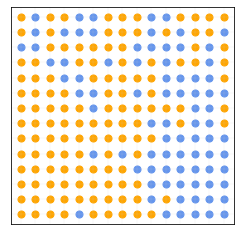

In [182]:
fig = plt.figure(figsize=(4, 4),facecolor='white')

ax = fig.add_subplot(111)
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    if locadis[loc][0] != '':
        plt.scatter(loc[0], loc[1], color=acol[locadis[loc][0]], s=50)
#plt.title("Skill Atoms",fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P1.pdf') 

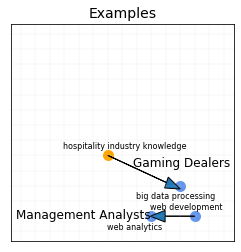

In [183]:
fig = plt.figure(figsize=(4, 4),facecolor='white')

ax = fig.add_subplot(111)
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for j in ['Gaming Dealers', 'Management Analysts']:
    ji=list(jawd[j].keys())[0]
    jd=list(jawd[j].keys())[-1]
    plt.scatter(aloc[ji][0], aloc[ji][1], color=acol[ji], s=100)
    plt.scatter(aloc[jd][0], aloc[jd][1], color=acol[jd], s=100)
    plt.text(aloc[ji][0]-8, aloc[ji][1]-2, gi[ji], fontsize=8)
    plt.text(aloc[jd][0]-8, aloc[jd][1]+1, di[jd], fontsize=8)
#plt.text(-15,2,'Career/Technical Education \n Teachers, Middle School', color="cornflowerblue", fontsize=14)
plt.text(0,-4,'Gaming Dealers', fontsize=12)
plt.text(-21,-12,'Management Analysts', fontsize=12)

j='Gaming Dealers'
plt.arrow(aloc[list(jawd[j].keys())[-1]][0], aloc[list(jawd[j].keys())[-1]][1], 
          aloc[list(jawd[j].keys())[0]][0]-aloc[list(jawd[j].keys())[-1]][0]-2.5, 
          aloc[list(jawd[j].keys())[0]][1]-aloc[list(jawd[j].keys())[-1]][1]+0.5, 
              head_width=1.8) 

j='Management Analysts'
plt.arrow(aloc[list(jawd[j].keys())[-1]][0], aloc[list(jawd[j].keys())[-1]][1], 
          aloc[list(jawd[j].keys())[0]][0]-aloc[list(jawd[j].keys())[-1]][0]+2.5, 
          aloc[list(jawd[j].keys())[0]][1]-aloc[list(jawd[j].keys())[-1]][1], 
              head_width=1.8) 

plt.title("Examples",fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P2_new2.pdf')

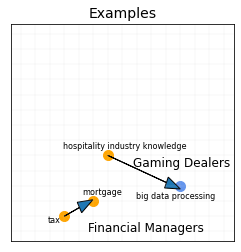

In [185]:
# fig = plt.figure(figsize=(4, 4),facecolor='white')

# ax = fig.add_subplot(111)
# for x in gridx:
#     plt.axvline(x=x, color='lightgrey',alpha=0.1)
# for y in gridy:
#     plt.axhline(y=y, color='lightgrey',alpha=0.1)

# #plt.text(-15,2,'Career/Technical Education \n Teachers, Middle School', color="cornflowerblue", fontsize=14)
# plt.text(0,-4,'Gaming Dealers', fontsize=12)
# plt.text(-8,-14,'Financial Managers', fontsize=12)

# j='Gaming Dealers'
# ji=list(jawd[j].keys())[0]
# jd=list(jawd[j].keys())[-1]
# plt.scatter(aloc[ji][0], aloc[ji][1], color=acol[ji], s=100)
# plt.scatter(aloc[jd][0], aloc[jd][1], color=acol[jd], s=100)
# plt.text(aloc[ji][0]-8, aloc[ji][1]-2, gi[ji], fontsize=8)
# plt.text(aloc[jd][0]-8, aloc[jd][1]+1, di[jd], fontsize=8)
# plt.arrow(aloc[list(jawd[j].keys())[-1]][0], aloc[list(jawd[j].keys())[-1]][1], 
#           aloc[list(jawd[j].keys())[0]][0]-aloc[list(jawd[j].keys())[-1]][0]-2.5, 
#           aloc[list(jawd[j].keys())[0]][1]-aloc[list(jawd[j].keys())[-1]][1]+0.5, 
#               head_width=1.8) 

# j='Financial Managers'
# ji=list(jawd[j].keys())[0]
# jd=list(jawd[j].keys())[-1]
# plt.scatter(aloc[ji][0], aloc[ji][1], color=acol[ji], s=100)
# plt.scatter(aloc[jd][0], aloc[jd][1], color=acol[jd], s=100)
# plt.text(aloc[ji][0]-2, aloc[ji][1]+1, gi[ji], fontsize=8)
# plt.text(aloc[jd][0]-3, aloc[jd][1]-1, di[jd], fontsize=8)
# plt.arrow(aloc[list(jawd[j].keys())[-1]][0], aloc[list(jawd[j].keys())[-1]][1], 
#           aloc[list(jawd[j].keys())[0]][0]-aloc[list(jawd[j].keys())[-1]][0]-2.5, 
#           aloc[list(jawd[j].keys())[0]][1]-aloc[list(jawd[j].keys())[-1]][1]-1, 
#               head_width=1.8) 

# plt.title("Examples",fontsize=14)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
# plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P2_new1.pdf')

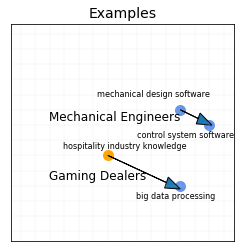

In [186]:
# fig = plt.figure(figsize=(4, 4),facecolor='white')

# ax = fig.add_subplot(111)
# for x in gridx:
#     plt.axvline(x=x, color='lightgrey',alpha=0.1)
# for y in gridy:
#     plt.axhline(y=y, color='lightgrey',alpha=0.1)

# #plt.text(-15,2,'Career/Technical Education \n Teachers, Middle School', color="cornflowerblue", fontsize=14)
# plt.text(-15,-6,'Gaming Dealers', fontsize=12)
# plt.text(-15,3,'Mechanical Engineers', fontsize=12)

# j='Gaming Dealers'
# ji=list(jawd[j].keys())[0]
# jd=list(jawd[j].keys())[-1]
# plt.scatter(aloc[ji][0], aloc[ji][1], color=acol[ji], s=100)
# plt.scatter(aloc[jd][0], aloc[jd][1], color=acol[jd], s=100)
# plt.text(aloc[ji][0]-8, aloc[ji][1]-2, gi[ji], fontsize=8)
# plt.text(aloc[jd][0]-8, aloc[jd][1]+1, di[jd], fontsize=8)
# plt.arrow(aloc[list(jawd[j].keys())[-1]][0], aloc[list(jawd[j].keys())[-1]][1], 
#           aloc[list(jawd[j].keys())[0]][0]-aloc[list(jawd[j].keys())[-1]][0]-2.5, 
#           aloc[list(jawd[j].keys())[0]][1]-aloc[list(jawd[j].keys())[-1]][1]+0.5, 
#               head_width=1.8) 

# j='Mechanical Engineers'
# ji=list(jawd[j].keys())[0]
# jd=list(jawd[j].keys())[-1]
# plt.scatter(aloc[ji][0], aloc[ji][1], color=acol[ji], s=100)
# plt.scatter(aloc[jd][0], aloc[jd][1], color=acol[jd], s=100)
# plt.text(aloc[ji][0]-13, aloc[ji][1]-2, gi[ji], fontsize=8)
# plt.text(aloc[jd][0]-15, aloc[jd][1]+2, di[jd], fontsize=8)
# plt.arrow(aloc[list(jawd[j].keys())[-1]][0], aloc[list(jawd[j].keys())[-1]][1], 
#           aloc[list(jawd[j].keys())[0]][0]-aloc[list(jawd[j].keys())[-1]][0]-2, 
#           aloc[list(jawd[j].keys())[0]][1]-aloc[list(jawd[j].keys())[-1]][1]+1, 
#               head_width=1.8) 

# plt.title("Examples",fontsize=14)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
# plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P2_new3.pdf')

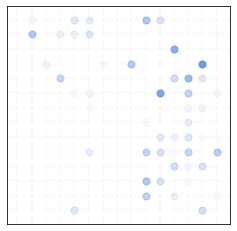

In [32]:
# rising machine atoms without labels
fig = plt.figure(figsize=(4, 4),facecolor='white')

ax = fig.add_subplot(111)
k=1
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    at=locadis[loc][0]
    if at != '':
        alp=ad[at]
        if alp>0 and acol[at]=='cornflowerblue':
            plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1), s=50)
#         if at in gi2 and acol[at]=='cornflowerblue':
#             plt.text(loc[0], loc[1], gi2[at], fontsize=10)
#         elif acol[at]=='cornflowerblue':
#             plt.text(loc[0], loc[1], str(at), fontsize=10)
#plt.title("Rising Skill Atoms",fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P3_v3.pdf')

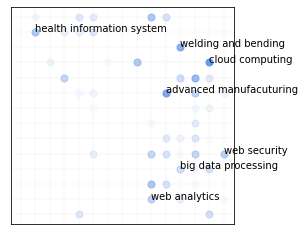

In [191]:
# rising machine atoms

gi2={}
gi2[121]="cloud computing"
gi2[48]="advanced manufacuturing"
gi2[18]='welding and bending'
gi2[82]='big data processing'
gi2[202]='web analytics'
gi2[7]='health information system'
gi2[15]='web security'

fig = plt.figure(figsize=(4, 4),facecolor='white')

ax = fig.add_subplot(111)
k=1
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    at=locadis[loc][0]
    if at != '':
        alp=ad[at]
        if alp>0 and acol[at]=='cornflowerblue':
            plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1), s=50)
        if at in gi2 and acol[at]=='cornflowerblue':
            plt.text(loc[0], loc[1], gi2[at], fontsize=10)
#         elif acol[at]=='cornflowerblue':
#             plt.text(loc[0], loc[1], str(at), fontsize=10)
#plt.title("Rising Skill Atoms",fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P3_v2.pdf')

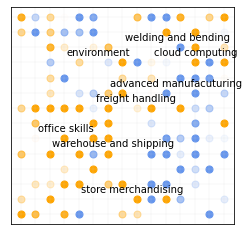

In [94]:
# # rising atoms
# fig = plt.figure(figsize=(4, 4),facecolor='white')

# ax = fig.add_subplot(111)

# for x in gridx:
#     plt.axvline(x=x, color='lightgrey',alpha=0.1)
# for y in gridy:
#     plt.axhline(y=y, color='lightgrey',alpha=0.1)
# for loc in locadis:
#     at=locadis[loc][0]
#     if at != '':
#         alp=ad[at]
#         if alp>0:
#             plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1), s=50)
#         if at in gi:
#             plt.text(loc[0]-10, loc[1]+1, gi[at], fontsize=10)
# #plt.title("Rising Skill Atoms",fontsize=14)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

# plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P3.pdf')

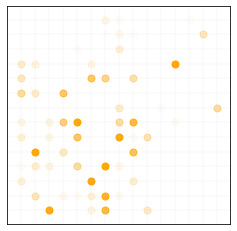

In [35]:
# declining human atoms: without labels
fig = plt.figure(figsize=(4, 4),facecolor='white')
k=1
ax = fig.add_subplot(111)
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    at=locadis[loc][0]
    if at != '':
        alp=ad[at]
        if alp<0 and acol[at]=="orange":
            plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(abs(alp*k),1),s=50)
#         if at in di and acol[at]=="orange":
#             plt.text(loc[0], loc[1], di[at], fontsize=10)
#plt.title("Decling Skill Atoms", fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P4_v3.pdf')

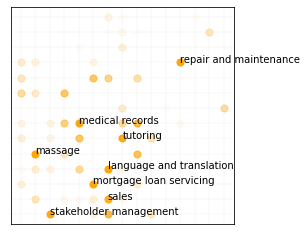

In [189]:
# declining human atoms

di={}
di[73]='medical records'
di[156]="massage"
di[89]='mortgage loan servicing'
di[75]="repair and maintenance"
di[3]="language and translation"
di[5]="tutoring"
di[36]="stakeholder management"
di[113]="sales"
#di[13]="investment and assest"
#di[105]="hospitality industry knowledge"

fig = plt.figure(figsize=(4, 4),facecolor='white')
k=1
ax = fig.add_subplot(111)
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    at=locadis[loc][0]
    if at != '':
        alp=ad[at]
        if alp<0 and acol[at]=="orange":
            plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(abs(alp*k),1),s=50)
        if at in di and acol[at]=="orange":
            plt.text(loc[0], loc[1], di[at], fontsize=10)
#plt.title("Decling Skill Atoms", fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P4_v2.pdf')

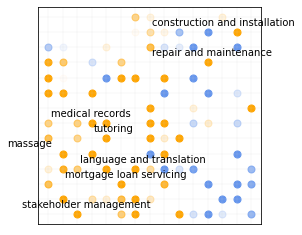

In [95]:
# declining atoms
# fig = plt.figure(figsize=(4, 4),facecolor='white')

# ax = fig.add_subplot(111)
# for x in gridx:
#     plt.axvline(x=x, color='lightgrey',alpha=0.1)
# for y in gridy:
#     plt.axhline(y=y, color='lightgrey',alpha=0.1)
# for loc in locadis:
#     at=locadis[loc][0]
#     if at != '':
#         alp=ad[at]
#         if alp<0:
#             plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(abs(alp*k),1),s=50)
#         if at in di:
#             plt.text(loc[0]-10, loc[1]+1, di[at], fontsize=10)
# #plt.title("Decling Skill Atoms", fontsize=14)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)

# plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P4.pdf')